In [1]:
%config Completer.use_jedi = False
import os

import numpy as np
import pandas as pd

import anndata
import scanpy as sc

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
from matplotlib import gridspec
import matplotlib as mpl
import seaborn as sns

from collections import defaultdict

#if __name__ == '__main__':
    
print('Load interaction')
fn_int = '/home/yike/phd/dengue/data/interaction_unpacked_mouse.tsv'
interactions = pd.read_csv(fn_int, sep='\t')[['gene_name_a', 'gene_name_b']]
ga, gb = interactions['gene_name_a'], interactions['gene_name_b']

#if True:
print('Load high-quality cells only')
fn_h5ad = '/home/yike/phd/dengue/data/mergedata_20210310.h5ad'
adata = anndata.read_h5ad(fn_h5ad)
adata = adata[adata.obs['cell_quality'] == 'high']
adata.obs['dataset'] = adata.obs['platform'].replace({
    '10X': 'child',
    'plate': 'adult'   
})
adata.obs['sick'] = adata.obs['Condition'].replace({
    'S_dengue': 'sick',
    'dengue': 'sick',
    'DWS': 'sick'
})
sc.pp.normalize_total(adata, target_sum=1e6) #normalize data to CPM (counts per million)
        
print('Restrict to interaction genes')
genes = np.unique(interactions)
adatag = adata[:, genes]

Load interaction
Load high-quality cells only


/usr/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Trying to set attribute `.obs` of view, copying.


Restrict to interaction genes


In [2]:
#fig, ax = plt.subplots(figsize=(6,6), dpi=300, facecolor='white')
#sns.heatmap(np.log10(0.1 + adata.obs[['ID', 'cell_type']].groupby(['ID', 'cell_type']).size().unstack(fill_value=0)))

In [3]:
#(adata_children.obs[['ID', 'Condition']].groupby(['ID', 'Condition']).size().unstack(fill_value=0)>0).sum()

In [2]:
adata_children = adata[adata.obs['dataset'] == 'child']
adata_adults = adata[adata.obs['dataset'] == 'adult']

conditions = list(adata.obs['Condition'].astype('category').cat.categories)
datasets = list(adata.obs['dataset'].astype('category').cat.categories)
sicks = list(adata.obs['sick'].astype('category').cat.categories)

from collections import defaultdict
adata_dic = {}
n_ID = {}
l_ID = {}

for condition in conditions:
    for dataset in datasets:
        adata_dic[(condition, dataset)] = adata[adata.obs['Condition'] == condition][adata[adata.obs['Condition'] == condition].obs['dataset'] == dataset]
        n_ID[(condition, dataset)] = len(adata_dic[(condition, dataset)].obs['ID'].astype('category').cat.categories)
        l_ID[(condition, dataset)] = list(adata_dic[(condition, dataset)].obs['ID'].astype('category').cat.categories)
        
for sick in sicks:
    for dataset in datasets:
        adata_dic[(sick, dataset)] = adata[adata.obs['sick'] == sick][adata[adata.obs['sick'] == sick].obs['dataset'] == dataset]
        n_ID[(sick, dataset)] = len(adata_dic[(sick, dataset)].obs['ID'].astype('category').cat.categories)
        l_ID[(sick, dataset)] = list(adata_dic[(sick, dataset)].obs['ID'].astype('category').cat.categories)

In [19]:
from log2_FC_functions import log2_FC_all

gbs = ['B_cells', 'Monocytes', 'NK_cells', 'Plasmablasts', 'T_cells', 'cDCs', 'pDCs']

adata_gb = {}
log2_fc_all = {}
log2_fc_ave = pd.DataFrame([])

for gb in gbs:
    adata_gb[gb] = adata_children[adata_children.obs['cell_type'] == gb]
    
    log2_fc_all[gb] = log2_FC_all(adata.var_names.tolist(), adata_gb[gb], 'S_dengue', 'dengue', 'child')[1]
    log2_fc_all[gb]['cell_type']=[gb]*log2_fc_all[gb].shape[0]
    log2_fc_ave = pd.concat([log2_fc_ave, log2_fc_all[gb]])

log2_fc_ave['gene'] = log2_fc_ave.index.values
log2_fc_ave = log2_fc_ave.set_index('cell_type')

In [152]:
log2_fc_ave = pd.read_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/new_cts/log2_fc_ave_kids.tsv', index_col=0)
log2fc_ad = pd.read_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/new_cts/log2_fc_ave_adults.tsv', index_col=0)
#log2_fc_by_genes = pd.read_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/new_cts/log2_fc_by_genes.tsv', header=[0,1], index_col=0)
#top_inters_all = pd.read_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/new_cts/S_dengue_in_child_by_cell_type_top_inters.tsv', index_col=0)
#last_inters_all = pd.read_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/new_cts/S_dengue_in_child_by_cell_type_last_inters.tsv', index_col=0)

########################################### all genes in the dataset, but not compared by patient to patient
log2fc_kid_all = pd.read_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/new_cts/all_log2_fc_ave_kids.tsv', index_col=0) 
log2fc_ad_all = pd.read_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/new_cts/all_log2_fc_ave_adults.tsv', index_col=0) 

In [161]:
log2_fc_Mono = log2_fc_ave.loc['Monocytes'].sort_values('fold_2_change', ascending=False)
Mono_top50 = log2_fc_Mono.head(50)
Mono_last50 = log2_fc_Mono.tail(50)

In [162]:
Luca = pd.DataFrame([])
for gene in ['CXCL10', 'CCL2', 'CCL5', 'CXCL13', 'CXCR5', 'CCR2', 'CXCR3', 'CCR3']:
    g = log2_fc_ave[log2_fc_ave['gene'] == gene].T.head(1)
    g['gene'] = gene
    Luca = pd.concat([Luca, g], axis=0)
Luca.set_index('gene')

cell_type,B_cells,Monocytes,NK_cells,Plasmablasts,T_cells,cDCs,pDCs
gene,,,,,,,
CXCL10,-2.73325,-2.538432,-0.677717,1.250709,-2.067996,-2.413538,0.0
CCL2,0.336321,-3.546572,-0.588305,-0.442256,-0.728624,0.599606,0.0
CCL5,-0.756166,-0.130048,0.344712,-0.367028,-0.030184,-3.439164,-1.134558
CXCL13,0.0,0.0,0.0,0.386441,0.003053,0.0,0.0
CXCR5,0.343942,1.179351,-0.68278,-0.38392,0.911041,-2.241987,-0.988056
CCR2,0.432507,0.929864,0.853366,1.72891,-0.826766,0.003324,-0.291443
CXCR3,0.722018,-0.612802,0.85205,1.753582,0.510524,-0.251957,0.212946
CCR3,-0.683877,0.142752,-0.478246,0.054495,0.60691,0.0,0.755227


In [174]:
chem_up = pd.DataFrame([])
for gene in ['CCL2', 'CCL7', 'CCL8', 'CCL13']:
    g = log2fc_ad_all[log2fc_ad_all['gene'] == gene].T.head(1)
    g['gene'] = gene
    chem_up = pd.concat([chem_up, g], axis=0)
chem_up.set_index('gene')

cell_type,B_cells,Monocytes,NK_cells,Plasmablasts,T_cells,cDCs,pDCs
gene,,,,,,,
CCL2,0.034194,-2.581264,0.446821,0.0,0.03329,6.609555,0.316833
CCL7,0.0,1.328439,0.008019,0.0,0.003488,0.0,0.0
CCL8,0.089909,-0.278431,0.52961,0.086908,-0.111932,0.0,0.343882
CCL13,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [164]:
chem_down = pd.DataFrame([])
for gene in ['XCL1', 'XCR1']:
    g = log2_fc_ave[log2_fc_ave['gene'] == gene].T.head(1)
    g['gene'] = gene
    chem_down = pd.concat([chem_down, g], axis=0)
chem_down.set_index('gene')

cell_type,B_cells,Monocytes,NK_cells,Plasmablasts,T_cells,cDCs,pDCs
gene,,,,,,,
XCL1,-1.792225,-3.252917,-0.608962,-3.511753,-1.760358,0.427704,-2.117612
XCR1,0.146109,1.139139,0.334905,0.293297,0.0,1.089948,0.0


In [200]:
log2fc_kid_all[log2fc_kid_all['gene'] == 'CCL24']

,fold_2_change,comp_frac,gene
cell_type,,,
B_cells,0.000000,0.00000,CCL24
Monocytes,0.187898,0.21875,CCL24
NK_cells,0.000000,0.00000,CCL24
Plasmablasts,0.039124,0.12500,CCL24
T_cells,0.000000,0.00000,CCL24
cDCs,0.000000,0.00000,CCL24
pDCs,0.000000,0.00000,CCL24


In [201]:
log2fc_ad_all[log2fc_ad_all['gene'] == 'CCL24']

,fold_2_change,comp_frac,gene
cell_type,,,
B_cells,0.0,0.0,CCL24
Monocytes,0.0,0.0,CCL24
NK_cells,0.0,0.0,CCL24
Plasmablasts,0.0,0.0,CCL24
T_cells,0.0,0.0,CCL24
cDCs,0.0,0.0,CCL24
pDCs,0.0,0.0,CCL24


In [16]:
# interactions[(interactions['gene_name_a'] == 'CCR2') | (interactions['gene_name_b'] == 'CCR2')]

In [14]:
#last_inters_Mono[last_inters_Mono['gene_name_a'] == 'XCL1']


# inters with endothellial or epidermal ['FLT1', 'NRP1', 'ITGA10', 'ITGB3', 'RETN', 'AREG', 'ANGPT1', 'EREG', 'ACVRL1']
# ECM ['PLD2', 'FN1', 'COL8A2']
# communication of cells with their microenvironment 
# inters need further google ['MRC1', 'FLT3', 'NPW', 'IL1R1', 'IL23A', 'PLD2', 'ADORA2B', 'IL11RA']
# inters with Monocytes or immune ['CSF1', 'CD70' ] 
# strange ['INSL3', 'LRP5', 'ASGR2']
# 'ACVRL1': hemorrhagic telangiectasia type 2
# 'EPHA1', 'APP': nervous system, App AD

/usr/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


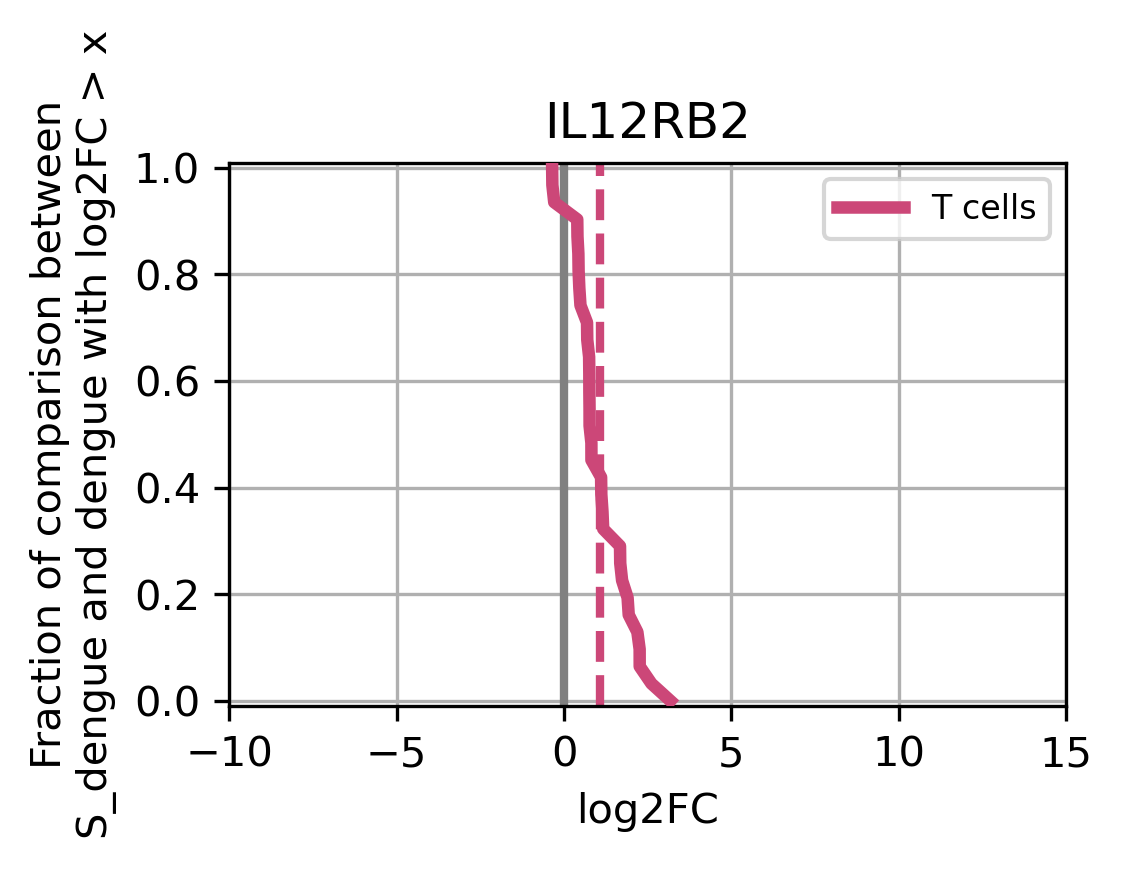

In [13]:
from log2_FC_functions import cul_plot_gene_cts
cul_plot_gene_cts(['IL12RB2'], adata, 'S_dengue', 'dengue', 'child', ['T_cells'])

/usr/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/yike/phd/dengue/dengue_children/log2_FC_functions.py:675: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([-10, -5, 0, 5, 10, 15], fontsize=15)
/home/yike/phd/dengue/dengue_children/log2_FC_functions.py:676: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=15)
/home/yike/phd/dengue/dengue_children/log2_FC_functions.py:675: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([-10, -5, 0, 5, 10, 15], fontsize=15)
/home/yike/phd/dengue/dengue_children/log2_FC_functions.py:676: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_ytick

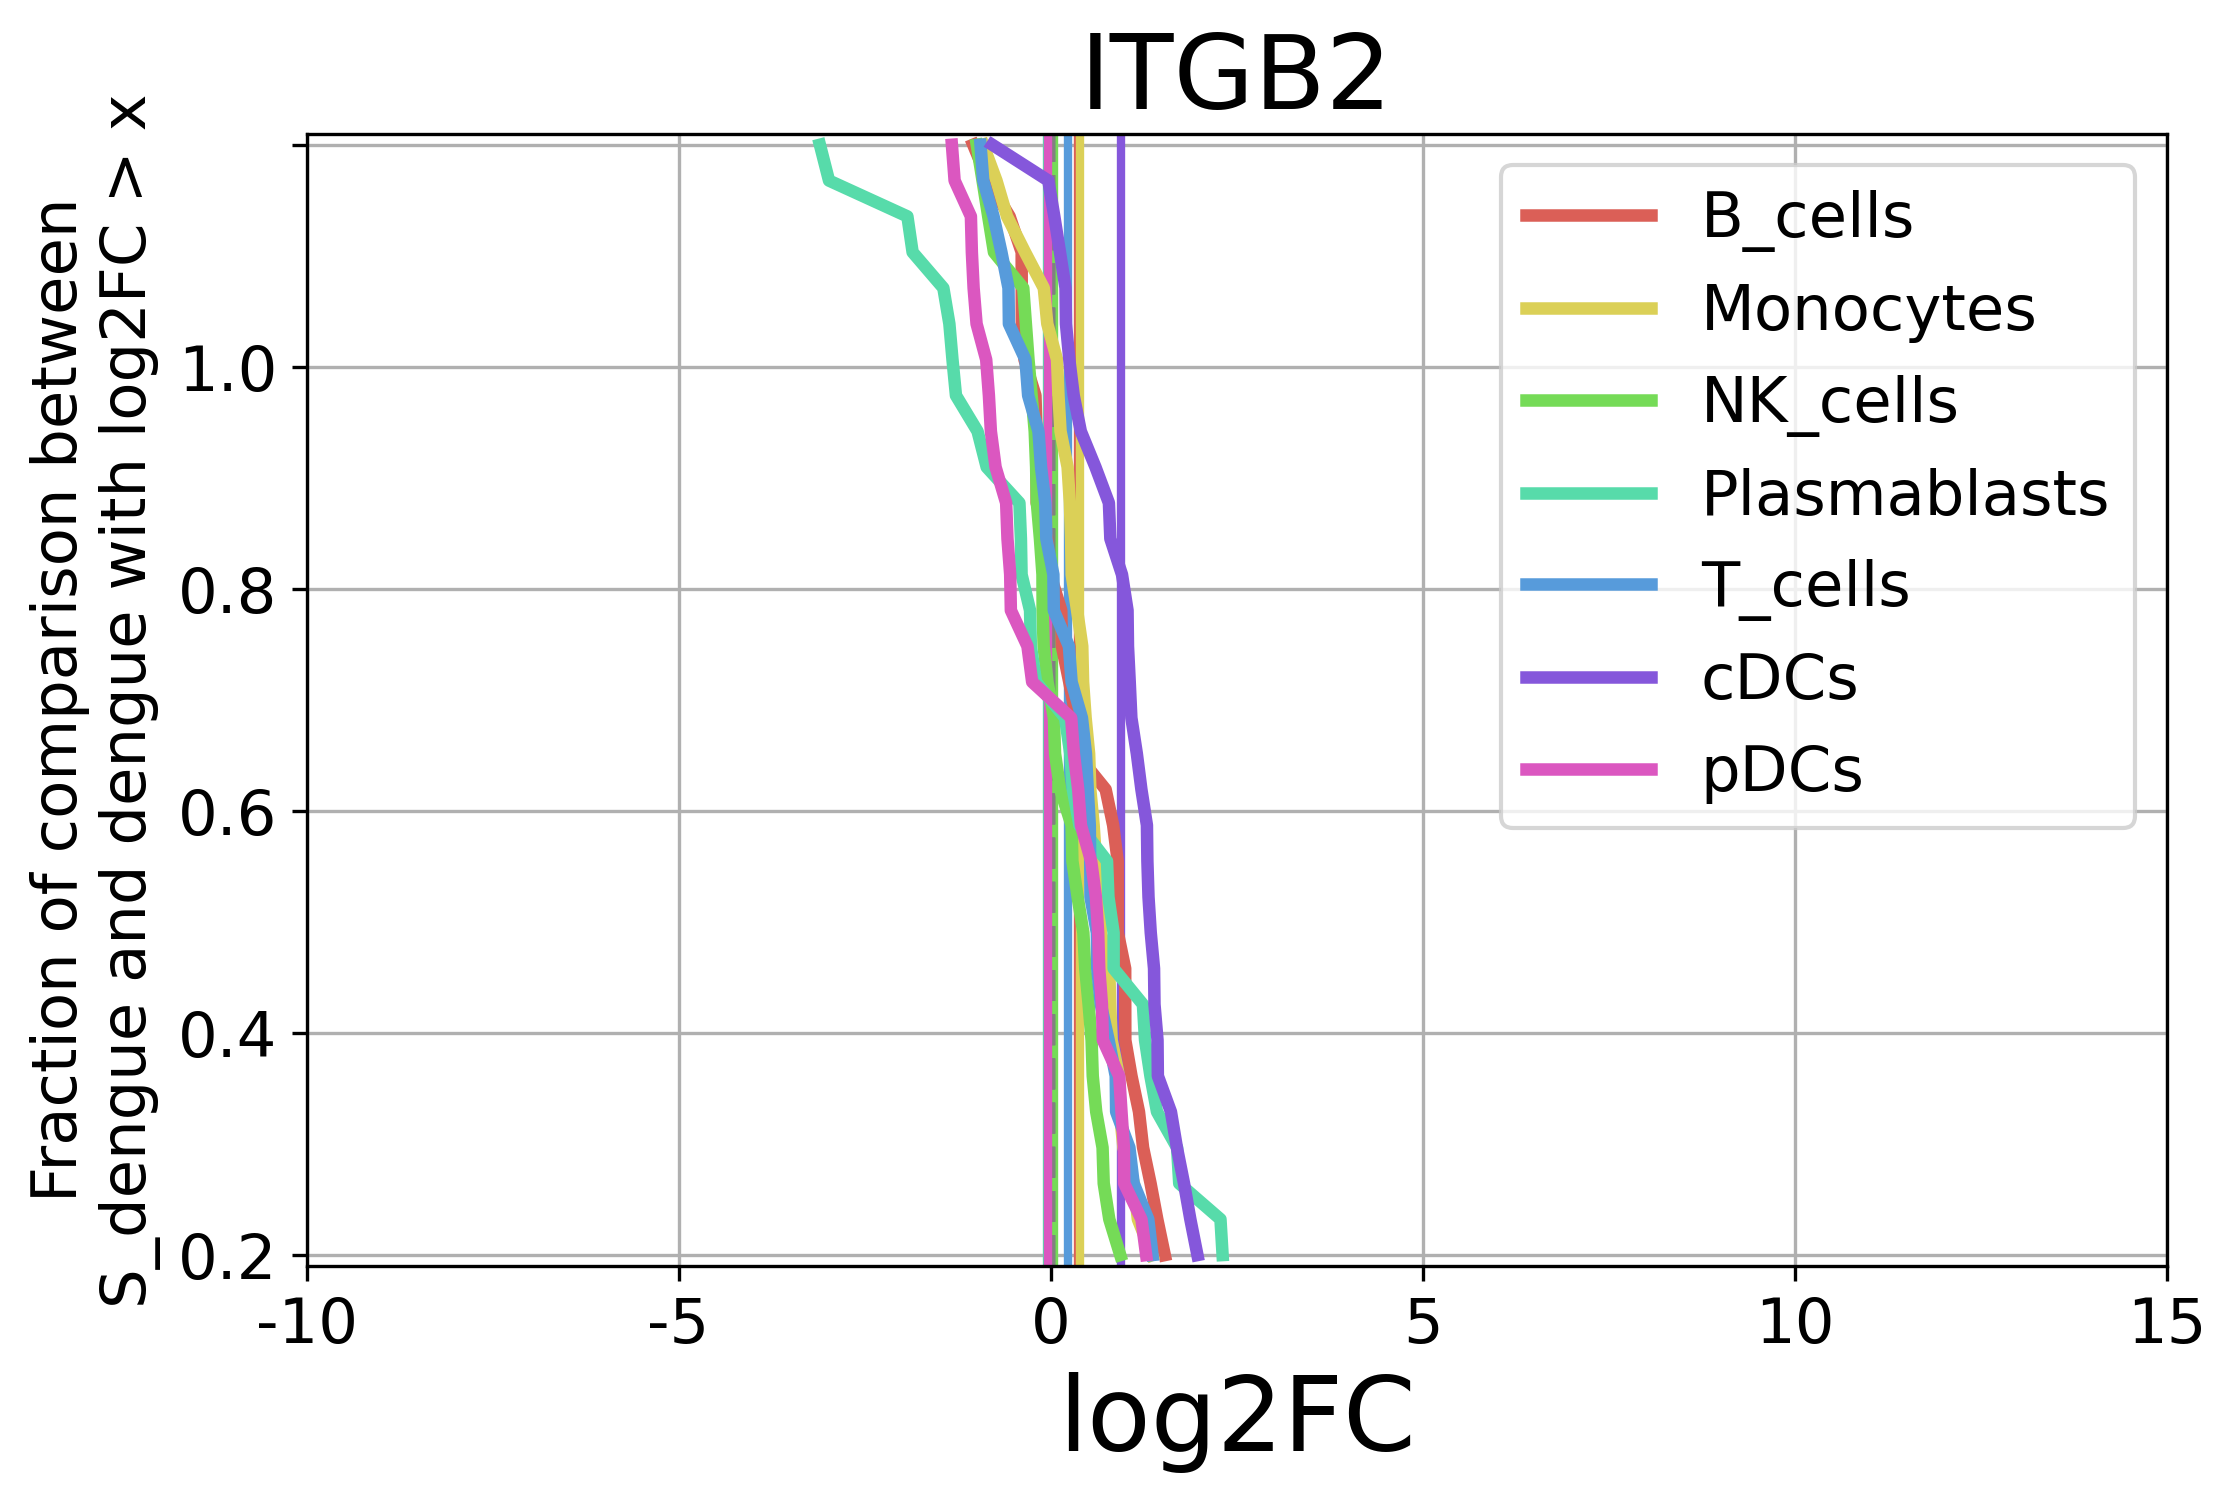

In [14]:
from log2_FC_functions import cul_plot_genes
cul_plot_genes(['ITGB2'], adata, 'S_dengue', 'dengue', 'child', 'cell_type')

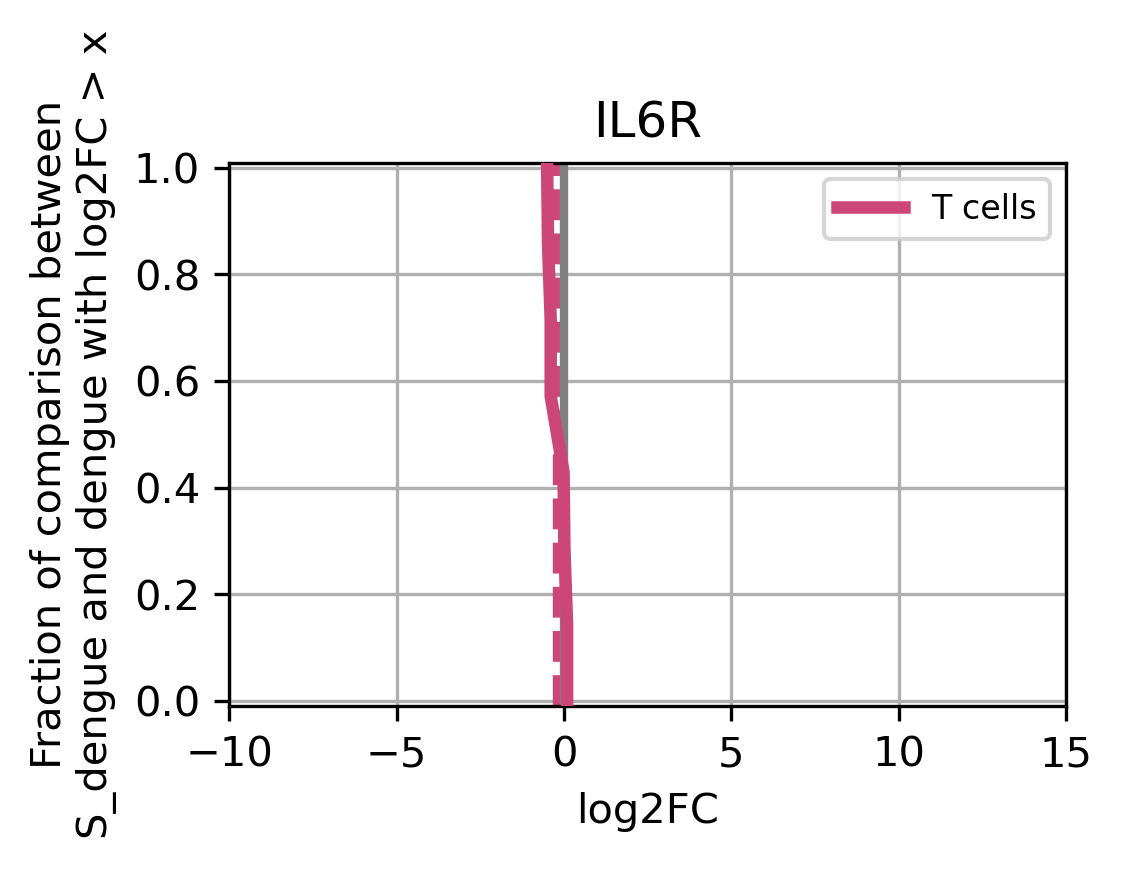

In [10]:
from log2_FC_functions import cul_plot_gene_cts
cul_plot_gene_cts(['IL6R'], adata, 'S_dengue', 'dengue', 'adult', ['T_cells'])

/usr/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/yike/phd/dengue/dengue_children/log2_FC_functions.py:675: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([-10, -5, 0, 5, 10, 15], fontsize=15)
/home/yike/phd/dengue/dengue_children/log2_FC_functions.py:676: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=15)
/home/yike/phd/dengue/dengue_children/log2_FC_functions.py:675: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([-10, -5, 0, 5, 10, 15], fontsize=15)
/home/yike/phd/dengue/dengue_children/log2_FC_functions.py:676: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_ytick

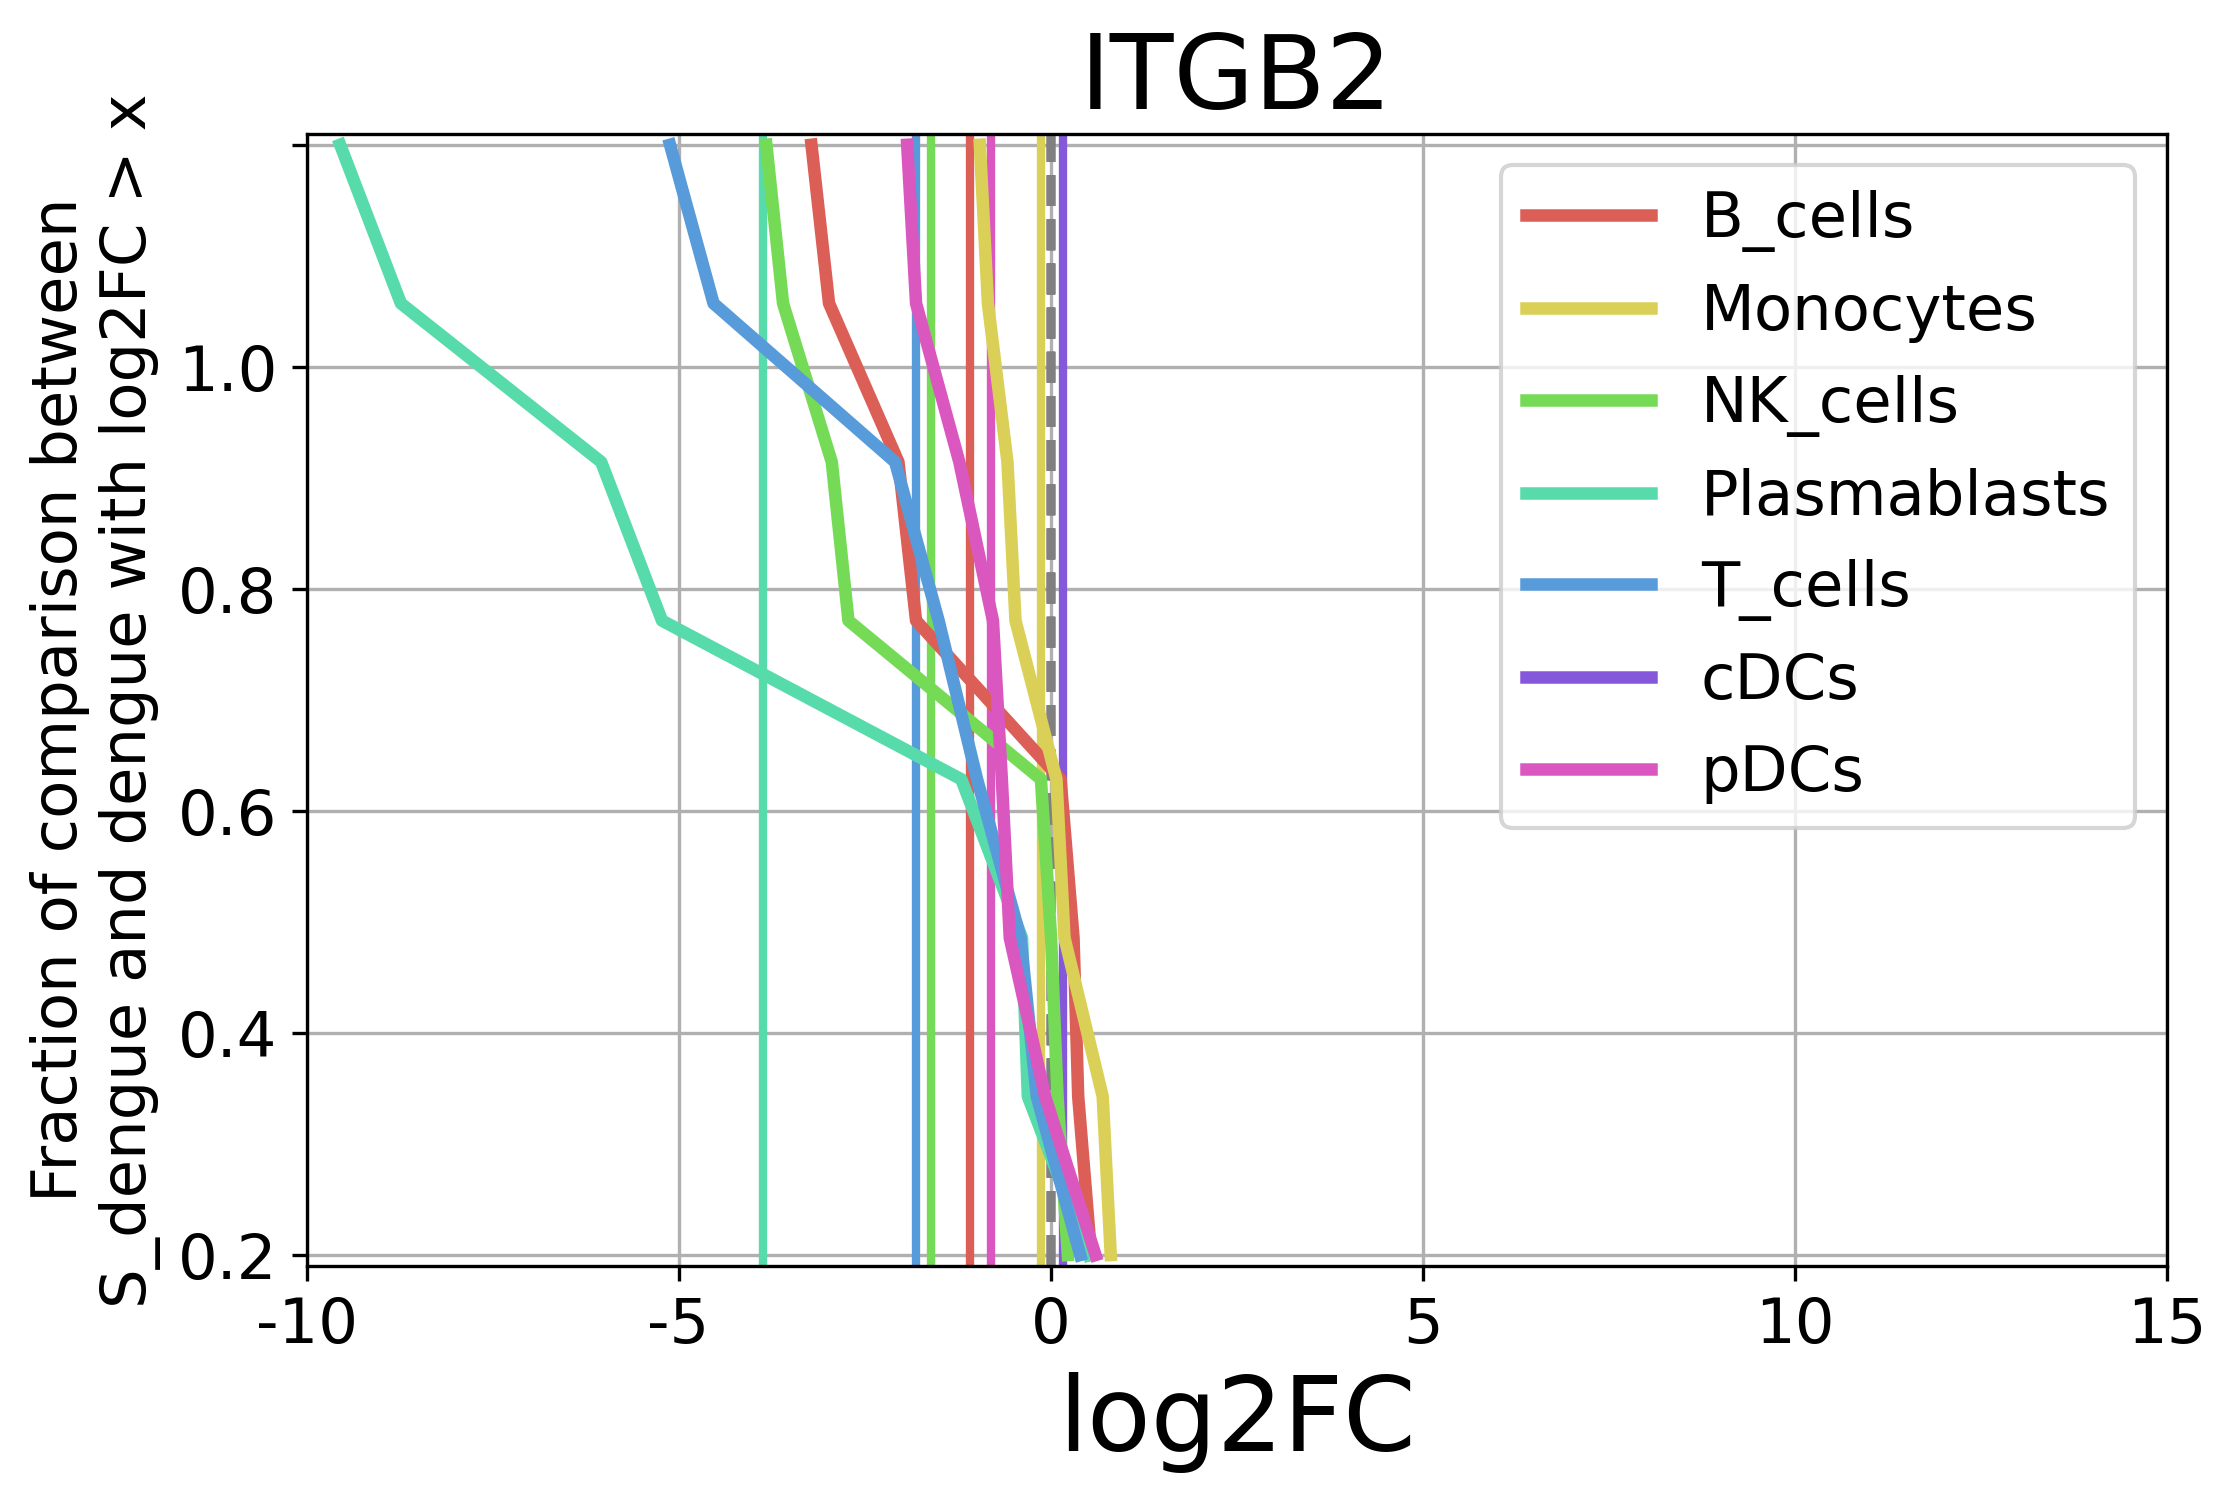

In [15]:
from log2_FC_functions import cul_plot_genes
cul_plot_genes(['ITGB2'], adata, 'S_dengue', 'dengue', 'adult', 'cell_type')

In [200]:
# calculate the number of interactions within immune cells, expression > 10 %
# interactions
# genes
# adatag
from collections import defaultdict

adatag_children = adatag[adatag.obs['dataset'] == 'child']
cell_types = ['B_cells', 'Monocytes', 'NK_cells', 'Plasmablasts', 'T_cells', 'cDCs', 'pDCs']
conditions = ['S_dengue', 'dengue', 'DWS', 'Healthy']
from collections import defaultdict
adatag_ch_ct_cd = {}
for cell_type in cell_types:
    for condition in conditions:
        adatag_ch_ct_cd[(cell_type, condition)] = adatag_children[adatag_children.obs['cell_type'] == cell_type][adatag_children[adatag_children.obs['cell_type'] == cell_type].obs['Condition'] == condition] 

gene_exp = {}
for key in adatag_ch_ct_cd.keys():
    exp = (adatag_ch_ct_cd[key].X > 0).toarray().mean(axis=0)
    gene_exp[key] = pd.DataFrame(exp, index=adatag_ch_ct_cd[key].var.index, columns=[['gene_expre']])
    
inters_im = defaultdict(list)
for _, row in interactions.iterrows():
    ga = row['gene_name_a']
    gb = row['gene_name_b']
    for condition in conditions:
        for ct1 in cell_types:
            for ct2 in cell_types:
                if (gene_exp[(ct1, condition)].loc[ga][0] > 0.1) & (gene_exp[(ct2, condition)].loc[gb][0] > 0.1):
                    inters_im[(ct1, ct2, condition)].append([ga, gb])
                elif (gene_exp[(ct1, condition)].loc[gb][0] > 0.1) & (gene_exp[(ct2, condition)].loc[ga][0] > 0.1):
                    inters_im[(ct1, ct2, condition)].append([gb, ga])
                else:
                    pass

##################################################
#its = pd.DataFrame([])
#for key in inters.keys():
#    inter = pd.DataFrame(inters[key], index=pd.Index([key[0]+' '+key[1]+' '+key[2]]*len(inters[key])), columns=['ga', 'gb'])
#    its = pd.concat([its, inter])

#its.to_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/new_cts/all_inters_ct_ct_cond.tsv')

##################################################
intern_im = {}
for key in inters_im.keys():
    intern_im[key] = len(inters_im[key])

colors_im = {}
norm_intern_im = {}
for key in intern_im.keys():
    norm_intern_im[key] = (intern_im[(key)] - min(intern_im.values()))/max(intern_im.values())
    colors_im[key] = plt.cm.get_cmap('plasma')(norm_intern_im[key])

/usr/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [70]:
# calculate the number of interactions between immune cells and endothelial cells (Kyle's dataset), expression > 10 %

adata_human_lung = sc.read_h5ad('/home/yike/phd/dengue/data/dataset_from_google/human_lung/human/human_lung_10X.h5ad')
adata_hl_endo = adata_human_lung[adata_human_lung.obs['compartment'] == 'Endothelial']

# matching = [s for s in adata_hl_endo.var.index if 'REF' in s]
genes_endo = np.setdiff1d(genes, np.array(['ERFE', 'NECTIN1', 'NECTIN2', 'NECTIN3', 'NECTIN4', 'VEGFD', 'VSIR']))
adata_hl_g = adata_hl_endo[:, genes_endo]

from collections import defaultdict

################################################# gene expression in immune cells at three conditions
adatag_children = adatag[adatag.obs['dataset'] == 'child']
cell_types = ['B_cells', 'Monocytes', 'NK_cells', 'Plasmablasts', 'T_cells', 'cDCs', 'pDCs']
conditions = ['S_dengue', 'dengue', 'DWS', 'Healthy']

adatag_ch_ct_cd = {}
for cell_type in cell_types:
    for condition in conditions:
        adatag_ch_ct_cd[(cell_type, condition)] = adatag_children[adatag_children.obs['cell_type'] == cell_type][adatag_children[adatag_children.obs['cell_type'] == cell_type].obs['Condition'] == condition] 

gene_exp_im = {}
for key in adatag_ch_ct_cd.keys():
    exp = (adatag_ch_ct_cd[key].X > 0).toarray().mean(axis=0)
    gene_exp_im[key] = pd.DataFrame(exp, index=adatag_ch_ct_cd[key].var.index, columns=[['gene_expre']])

################################################### gene expression in endothelial cells
endo_cts = list(adata_hl_g.obs.free_annotation.value_counts().index) #### need to remove cell types special for lung in next cell

adata_hl_dic = {}
for ct in endo_cts:
    adata_hl_dic[ct] = adata_hl_g[adata_hl_g.obs.free_annotation == ct]

gene_exp_ed = {}
for key in adata_hl_dic.keys():
    exp = (adata_hl_dic[key].X > 0).toarray().mean(axis=0)
    gene_exp_ed[key] = pd.DataFrame(exp, index=adata_hl_dic[key].var.index, columns=[['gene_expre']])

inters_ed = defaultdict(list)
for _, row in interactions.iterrows():
    ga = row['gene_name_a']
    gb = row['gene_name_b']
    for condition in conditions:
        for ct1 in cell_types:
            for ct2 in endo_cts:
                if ga not in genes_endo:
                    pass
                elif gb not in genes_endo:
                    pass
                else:
                    if (gene_exp_im[(ct1, condition)].loc[ga][0] > 0.1) & (gene_exp_ed[ct2].loc[gb][0] > 0.1):
                        inters_ed[(ct1, ct2, condition)].append([ga, gb])
                    elif (gene_exp_im[(ct1, condition)].loc[gb][0] > 0.1) & (gene_exp_ed[ct2].loc[ga][0] > 0.1):
                        inters_ed[(ct1, ct2, condition)].append([gb, ga])
                    else:
                        pass

intern_ed = {}
for key in inters_ed.keys():
    intern_ed[key] = len(inters_ed[key])

colors_ed = {}
norm_intern_ed = {}
for key in intern_ed.keys():
    norm_intern_ed[key] = (intern_ed[(key)] - min(intern_ed.values()))/max(intern_ed.values())
    colors_ed[key] = plt.cm.get_cmap('plasma')(norm_intern_ed[key])

# min(intern.values())   103
# max(intern.values())   405

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


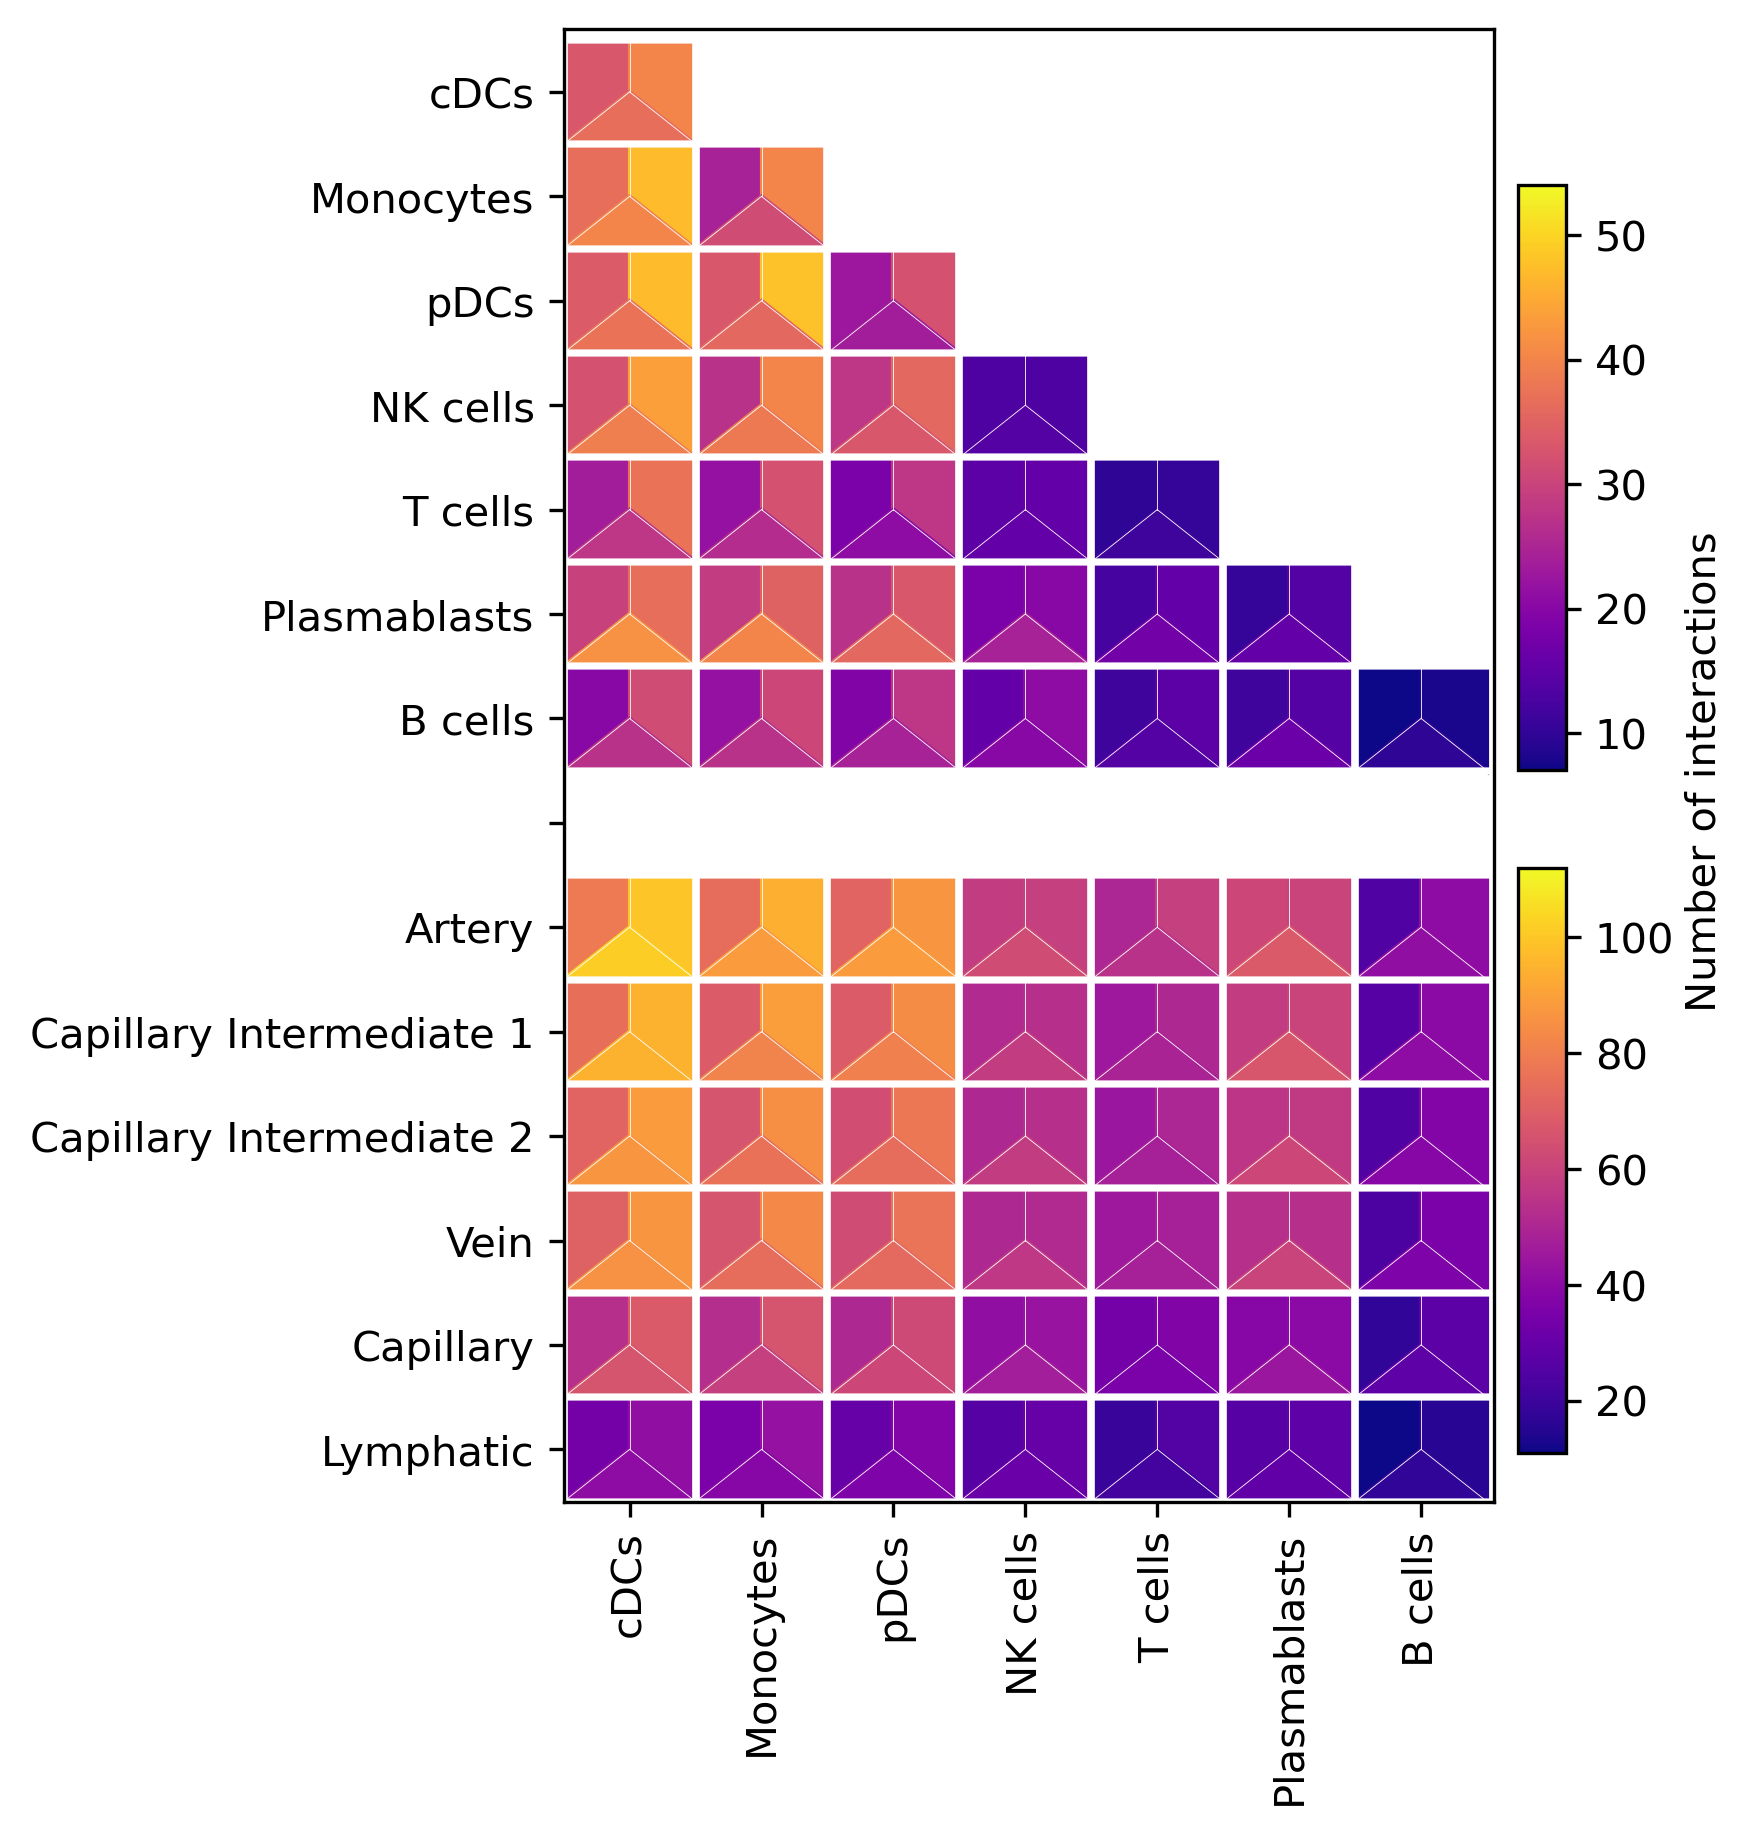

In [100]:
####################################### immune and immune: optimized cell_types, set S_dengue as the example
it_im = pd.DataFrame([])
ls_im = defaultdict(list)

for a in range(len(cell_types)):
    for b in range(len(cell_types)):
        ls_im[cell_types[a]].append(intern_im[(cell_types[a], cell_types[b], 'S_dengue')])
    it_im[cell_types[a]] = ls_im[cell_types[a]]
    
it_im.index = pd.Index(cell_types)  
# lower left: down, upper right: up

from scipy.spatial.distance import pdist 
distance = pdist(it_im.values) 

from scipy.cluster.hierarchy import linkage, leaves_list
lkg = linkage(distance, optimal_ordering=True)
best_order_im = leaves_list(lkg) 

it_im_new = it_im.iloc[best_order_im]
cts_im_op = list(it_im_new.index)

####################################### immune and endo: optimized cell_types, set S_dengue as the example
it_ed = pd.DataFrame([])
ls_ed = defaultdict(list)

### remove the cell types special for lung from endo_cts
# 'Capillary Aerocyte': alveolar type I capillaries
# 'Bronchial Vessel 1', 'Bronchial Vessel 2'
# 'Capillary Intermediate': precapillaries
ed_cts = ['Artery', 'Capillary', 'Vein', 'Capillary Intermediate 1', 'Capillary Intermediate 2', 'Lymphatic']

for a in range(len(cts_im_op)):
    for b in range(len(ed_cts)):
        ls_ed[cts_im_op[a]].append(intern_ed[(cts_im_op[a], ed_cts[b], 'S_dengue')])
    it_ed[cts_im_op[a]] = ls_ed[cts_im_op[a]]
    
it_ed.index = pd.Index(ed_cts)  
# lower left: down, upper right: up

from scipy.spatial.distance import pdist 
distance = pdist(it_ed.values) 

from scipy.cluster.hierarchy import linkage, leaves_list
lkg = linkage(distance, optimal_ordering=True)
best_order_ed = leaves_list(lkg) 

it_ed_new = it_ed.iloc[best_order_ed]
cts_ed_op = list(it_ed_new.index)

####################################### plot
colors_ed2 = {}
norm_intern_ed2 = {}
for key in intern_ed.keys():
    norm_intern_ed2[key] = (intern_ed[(key)] - min(intern_ed.values()))/max(intern_ed.values())
    colors_ed2[key] = plt.cm.get_cmap('plasma')(norm_intern_ed2[key])

colors_im2 = {}
norm_intern_im2 = {}
for key in intern_im.keys():
    norm_intern_im2[key] = (intern_im[(key)] - min(intern_im.values()))/max(intern_im.values())
    colors_im2[key] = plt.cm.get_cmap('plasma')(norm_intern_im2[key])
    
fig, ax = plt.subplots(figsize=[4, 6.5], dpi=300) 

cts = cts_ed_op + cts_im_op

for a in range(len(cts_im_op)):
    for b in range(len(cts)+1):
        ax.plot([a, a+0.5], [b, b+0.5], c='white', lw=0.2)
        ax.plot([a+0.5, a+1], [b+0.5, b], c='white', lw=0.2)
        ax.plot([a+0.5, a+0.5], [b+0.5, b+1], c='white', lw=0.2)
        ax.axvline(a, c='w')
        ax.axhline(b, c='w')
        
        if b < len(cts_ed_op):  ##############################  immune & endo 
            ######################################## dengue, left
            dots4 = [[a, b],
                    [a, b+1],
                    [a+0.5, b+1],
                    [a+0.5, b+0.5],
            ]
            e4 = mpatches.Polygon(np.array(dots4), color=colors_ed2[(list(reversed(cts_im_op))[a], cts[b], 'dengue')])
            ax.add_patch(e4)

            ######################################## S_dengue, right
            dots5 = [[a+0.5, b+0.5],
                    [a+0.5, b+1],
                    [a+1, b+1],
                    [a+1, b],
            ]
            e5 = mpatches.Polygon(np.array(dots5), color=colors_ed2[(list(reversed(cts_im_op))[a], cts[b], 'S_dengue')])
            ax.add_patch(e5)

            ######################################## Healthy, bottom
            dots6 = [[a+0.5, b+0.5],
                    [a, b],
                    [a+1, b],
            ]
            e6 = mpatches.Polygon(np.array(dots6), color=colors_ed2[(list(reversed(cts_im_op))[a], cts[b], 'Healthy')])
            ax.add_patch(e6)
                 
        else: ##############################  immune & immune 
            if len(cts_im_op)-1-a >= b-len(cts_ed_op):
                ######################################## dengue, left
                dots1 = [[a, b+1],
                        [a, b+2],
                        [a+0.5, b+2],
                        [a+0.5, b+1.5],
                ]
                e1 = mpatches.Polygon(np.array(dots1), color=colors_im2[(list(reversed(cts_im_op))[a], cts[b], 'dengue')])

                #patches.append(e1)
        #collection = PatchCollection(patches, color= colors)
        #ax.add_collection(collection)
                ax.add_patch(e1)

                ######################################## S_dengue, right
                dots2 = [[a+0.5, b+1.5],
                        [a+0.5, b+2],
                        [a+1, b+2],
                        [a+1, b+1],
                ]
                e2 = mpatches.Polygon(np.array(dots2), color=colors_im2[(list(reversed(cts_im_op))[a], cts[b], 'S_dengue')])
                ax.add_patch(e2)

                ######################################## Healthy, bottom
                dots3 = [[a+0.5, b+1.5],
                        [a, b+1],
                        [a+1, b+1],
                ]
                e3 = mpatches.Polygon(np.array(dots3), color=colors_im2[(list(reversed(cts_im_op))[a], cts[b], 'Healthy')])
                ax.add_patch(e3)
            else:
                pass

    ax.axvline(len(cts_im_op)+1, c='w')
    ax.axhline(len(cts_ed_op)+len(cts_im_op)+1, c='w')
ax.set_xlim([0,7.05])
ax.set_ylim([0,14.1])
ax.set_xticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5])
ax.set_yticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 13.5])
ax.set_xticklabels(list(reversed(['B cells', 'Plasmablasts', 'T cells', 'NK cells', 'pDCs', 'Monocytes', 'cDCs'])), rotation=90)
ax.set_yticklabels(cts_ed_op + ['', 'B cells', 'Plasmablasts', 'T cells', 'NK cells', 'pDCs', 'Monocytes', 'cDCs'])

norm_ed = mpl.colors.Normalize(vmin=min(intern_ed.values()), vmax=max(intern_ed.values()))
cmap_ed = plt.cm.get_cmap('plasma')
position_ed = fig.add_axes([0.92, 0.15, 0.04, 0.3]) # [left, bottom, width, top]
cbar_ed = plt.colorbar(plt.cm.ScalarMappable(norm=norm_ed, cmap=cmap_ed), cax=position_ed, ax=ax, fraction=0.01, pad=0.01, orientation='vertical')

norm_im = mpl.colors.Normalize(vmin=min(intern_im.values()), vmax=max(intern_im.values()))
cmap_im = plt.cm.get_cmap('plasma')
position_im = fig.add_axes([0.92, 0.5, 0.04, 0.3]) # [left, bottom, width, height]
cbar_im = plt.colorbar(plt.cm.ScalarMappable(norm=norm_im, cmap=cmap_im), cax=position_im, ax=ax, fraction=0.01, pad=0.01, orientation='vertical')

ax.text(8.5, 7, 'Number of interactions', verticalalignment='center', rotation=90)

plt.show()

In [25]:
adata_endo = sc.read_h5ad('../data/dataset_from_google/human_cell_landscape/adult_endo_HCL.h5ad')
no_exist = ['ADIPOQ', 'ADORA2A', 'AVPR1B', 'BMP10', 'BMP15', 'CCKAR', 'CCL27', 'CCR8', 'CER1', 'CSHL1', 'DSC1', 'EFNA2', 'EPHA8', 'FGF4', 'FGF6', 'FGF8', 'FSHB', 'FSHR', 'GALP', 'GALR3', 'GDF1', 'GDF2', 'GFRA4', 'GFRAL', 'GHSR', 'GNRHR', 'GP1BB', 'GPR151', 'GPR152', 'GPR25', 'IFNA4', 'IFNK', 'IFNL3', 'IL12B', 'IL21', 'IL25', 'IL36A', 'IL36B', 'IL9', 'INHBC', 'INSL5', 'LHCGR', 'MC3R', 'MC5R', 'MPL', 'MRGPRX1', 'MTNR1B', 'NMS', 'NPBWR1', 'NPS', 'NPSR1', 'NPVF', 'PRLH', 'PROKR2', 'PTH', 'RLN3', 'RXFP2', 'RXFP3', 'SSTR4', 'TRHR', 'TSHB', 'UTS2R', 'VSIR', 'WNT1']
genes_endo = np.setdiff1d(genes, np.array(no_exist))
adata_he_g = adata_endo[:, genes_endo]

from collections import defaultdict
################################################# gene expression in immune cells at three conditions
adatag_children = adatag[adatag.obs['dataset'] == 'child']
cell_types = ['B_cells', 'Monocytes', 'NK_cells', 'Plasmablasts', 'T_cells', 'cDCs', 'pDCs']
conditions = ['S_dengue', 'dengue', 'DWS', 'Healthy']

adatag_ch_ct_cd = {}
for cell_type in cell_types:
    for condition in conditions:
        adatag_ch_ct_cd[(cell_type, condition)] = adatag_children[adatag_children.obs['cell_type'] == cell_type][adatag_children[adatag_children.obs['cell_type'] == cell_type].obs['Condition'] == condition] 

gene_exp_im = {}
for key in adatag_ch_ct_cd.keys():
    exp = (adatag_ch_ct_cd[key].X > 0).toarray().mean(axis=0)
    gene_exp_im[key] = pd.DataFrame(exp, index=adatag_ch_ct_cd[key].var.index, columns=[['gene_expre']])

################################################### gene expression in endothelial cells
#he_cts = list(adata_he_g.obs['Celltype'].value_counts().index)
he_cts = ['Endothelial cell', 
          'Vascular endothelial cell', 
          'Lymphatic endothelial cell',
          'Arterial endothelial cell']

adata_he_dic = {}
for ct in he_cts:
    adata_he_dic[ct] = adata_he_g[adata_he_g.obs['Celltype'] == ct]

gene_exp_he = {}
for key in adata_he_dic.keys():
    exp = (adata_he_dic[key].X > 0).toarray().mean(axis=0)
    gene_exp_he[key] = pd.DataFrame(exp, index=adata_he_dic[key].var.index, columns=[['gene_expre']])

inters_he = defaultdict(list)
for _, row in interactions.iterrows():
    ga = row['gene_name_a']
    gb = row['gene_name_b']
    for condition in conditions:
        for ct1 in cell_types:
            for ct2 in he_cts:
                if ga not in genes_endo:
                    pass
                elif gb not in genes_endo:
                    pass
                else:
                    if (gene_exp_im[(ct1, condition)].loc[ga][0] > 0.1) & (gene_exp_he[ct2].loc[gb][0] > 0.1):
                        inters_he[(ct1, ct2, condition)].append([ga, gb])
                    elif (gene_exp_im[(ct1, condition)].loc[gb][0] > 0.1) & (gene_exp_he[ct2].loc[ga][0] > 0.1):
                        inters_he[(ct1, ct2, condition)].append([gb, ga])
                    else:
                        pass

intern_he = {}
for key in inters_he.keys():
    intern_he[key] = len(inters_he[key])

colors_he = {}
norm_intern_he = {}
for key in intern_he.keys():
    norm_intern_he[key] = (intern_he[(key)] - min(intern_he.values()))/max(intern_he.values())
    colors_he[key] = plt.cm.get_cmap('plasma')(norm_intern_he[key])

# min(intern.values())   103
# max(intern.values())   405

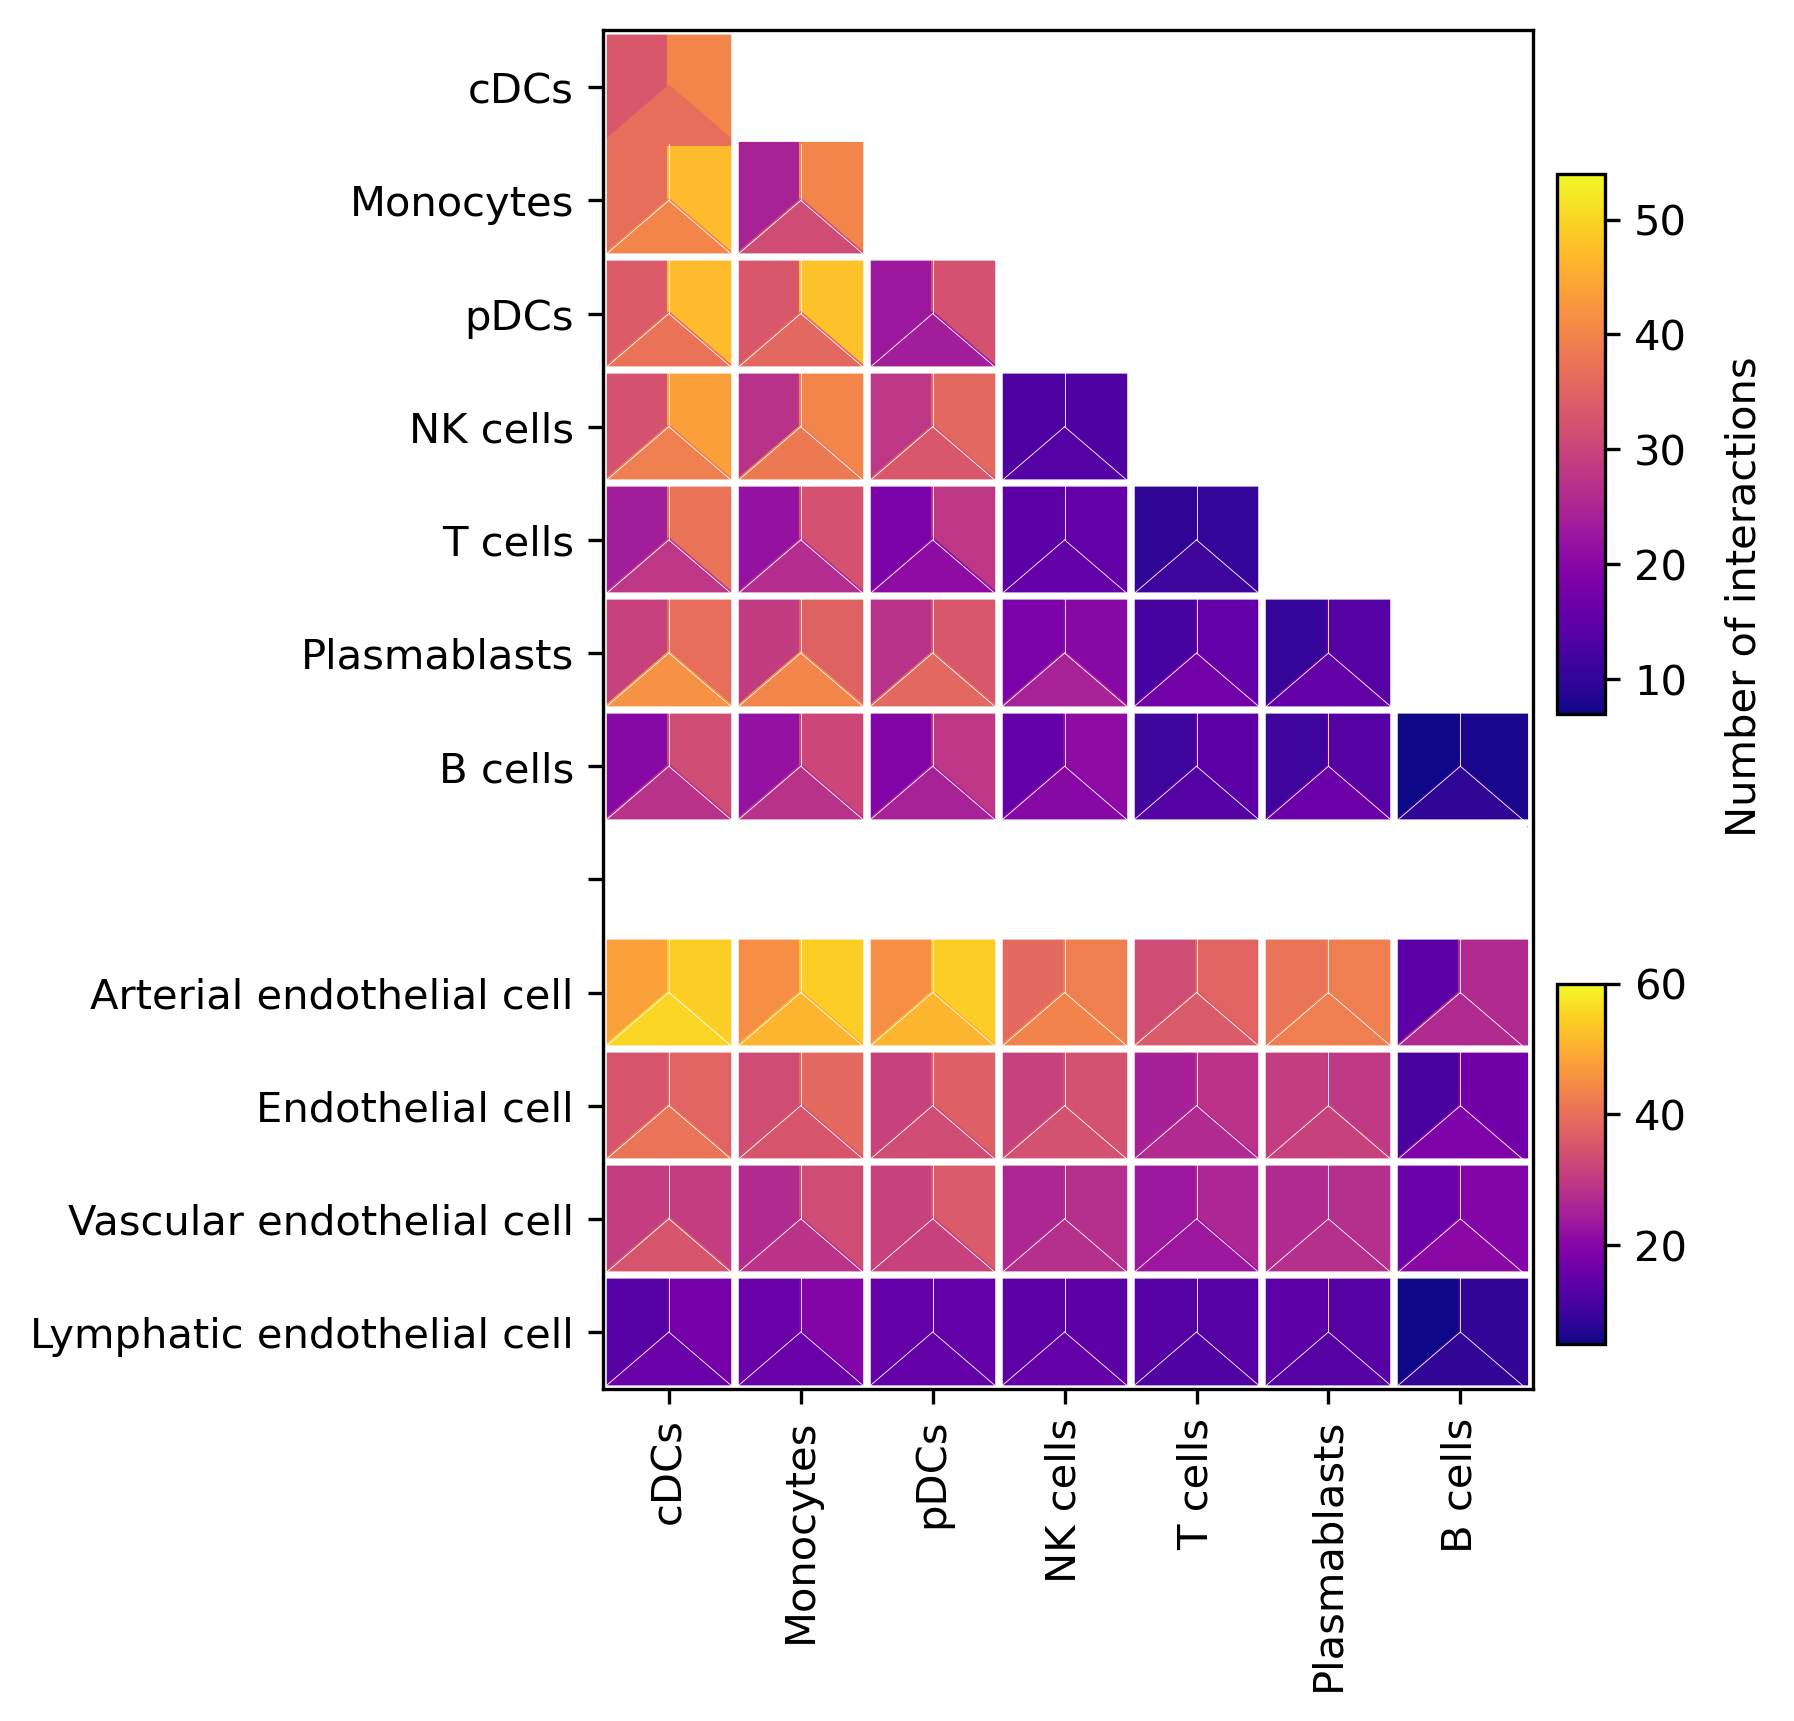

In [206]:
####################################### immune and immune: optimized cell_types, set S_dengue as the example
it_im = pd.DataFrame([])
ls_im = defaultdict(list)

for a in range(len(cell_types)):
    for b in range(len(cell_types)):
        ls_im[cell_types[a]].append(intern_im[(cell_types[a], cell_types[b], 'S_dengue')])
    it_im[cell_types[a]] = ls_im[cell_types[a]]
    
it_im.index = pd.Index(cell_types)  
# lower left: down, upper right: up

from scipy.spatial.distance import pdist 
distance = pdist(it_im.values) 

from scipy.cluster.hierarchy import linkage, leaves_list
lkg = linkage(distance, optimal_ordering=True)
best_order_im = leaves_list(lkg) 

it_im_new = it_im.iloc[best_order_im]
cts_im_op = list(it_im_new.index)

####################################### immune and endo: optimized cell_types, set S_dengue as the example
it_he = pd.DataFrame([])
ls_he = defaultdict(list)

### remove the cell types special for lung from endo_cts
# 'Capillary Aerocyte': alveolar type I capillaries
# 'Bronchial Vessel 1', 'Bronchial Vessel 2'
# 'Capillary Intermediate': precapillaries

for a in range(len(cts_im_op)):
    for b in range(len(he_cts)):
        ls_he[cts_im_op[a]].append(intern_he[(cts_im_op[a], he_cts[b], 'S_dengue')])
    it_he[cts_im_op[a]] = ls_he[cts_im_op[a]]
    
it_he.index = pd.Index(he_cts)  
# lower left: down, upper right: up

from scipy.spatial.distance import pdist 
distance = pdist(it_he.values) 

from scipy.cluster.hierarchy import linkage, leaves_list
lkg = linkage(distance, optimal_ordering=True)
best_order_he = leaves_list(lkg) 

it_he_new = it_he.iloc[best_order_he]
cts_he_op = list(it_he_new.index)

####################################### plot
colors_he2 = {}
norm_intern_he2 = {}
for key in intern_he.keys():
    norm_intern_he2[key] = (intern_he[(key)] - min(intern_he.values()))/max(intern_he.values())
    colors_he2[key] = plt.cm.get_cmap('plasma')(norm_intern_he2[key])

colors_im2 = {}
norm_intern_im2 = {}
for key in intern_im.keys():
    norm_intern_im2[key] = (intern_im[(key)] - min(intern_im.values()))/max(intern_im.values())
    colors_im2[key] = plt.cm.get_cmap('plasma')(norm_intern_im2[key])
    
fig, ax = plt.subplots(figsize=[4, 6], dpi=300) 

cts = cts_he_op + cts_im_op

for a in range(len(cts_im_op)):
    for b in range(len(cts)):
        ax.plot([a, a+0.5], [b, b+0.5], c='white', lw=0.2)
        ax.plot([a+0.5, a+1], [b+0.5, b], c='white', lw=0.2)
        ax.plot([a+0.5, a+0.5], [b+0.5, b+1], c='white', lw=0.2)
        ax.axvline(a, c='w')
        ax.axhline(b, c='w')
        
        if b < len(cts_he_op):  ##############################  immune & endo 
            ######################################## dengue, left
            dots4 = [[a, b],
                    [a, b+1],
                    [a+0.5, b+1],
                    [a+0.5, b+0.5],
            ]
            e4 = mpatches.Polygon(np.array(dots4), color=colors_he2[(list(reversed(cts_im_op))[a], cts[b], 'dengue')])
            ax.add_patch(e4)

            ######################################## S_dengue, right
            dots5 = [[a+0.5, b+0.5],
                    [a+0.5, b+1],
                    [a+1, b+1],
                    [a+1, b],
            ]
            e5 = mpatches.Polygon(np.array(dots5), color=colors_he2[(list(reversed(cts_im_op))[a], cts[b], 'S_dengue')])
            ax.add_patch(e5)

            ######################################## Healthy, bottom
            dots6 = [[a+0.5, b+0.5],
                    [a, b],
                    [a+1, b],
            ]
            e6 = mpatches.Polygon(np.array(dots6), color=colors_he2[(list(reversed(cts_im_op))[a], cts[b], 'Healthy')])
            ax.add_patch(e6)
                 
        else: ##############################  immune & immune 
            if len(cts_im_op)-1-a >= b-len(cts_he_op):
                #a >= b-len(cts_he_op):
                ######################################## dengue, left
                dots1 = [[a, b+1],
                        [a, b+2],
                        [a+0.5, b+2],
                        [a+0.5, b+1.5],
                ]
                e1 = mpatches.Polygon(np.array(dots1), color=colors_im2[(list(reversed(cts_im_op))[a], cts[b], 'dengue')])

                #patches.append(e1)
        #collection = PatchCollection(patches, color= colors)
        #ax.add_collection(collection)
                ax.add_patch(e1)

                ######################################## S_dengue, right
                dots2 = [[a+0.5, b+1.5],
                        [a+0.5, b+2],
                        [a+1, b+2],
                        [a+1, b+1],
                ]
                e2 = mpatches.Polygon(np.array(dots2), color=colors_im2[(list(reversed(cts_im_op))[a], cts[b], 'S_dengue')])
                ax.add_patch(e2)

                ######################################## Healthy, bottom
                dots3 = [[a+0.5, b+1.5],
                        [a, b+1],
                        [a+1, b+1],
                ]
                e3 = mpatches.Polygon(np.array(dots3), color=colors_im2[(list(reversed(cts_im_op))[a], cts[b], 'Healthy')])
                ax.add_patch(e3)
            else:
                pass

    ax.axvline(len(cts_im_op)+1, c='w')
    ax.axhline(len(cts_he_op)+len(cts_im_op)+1, c='w')
ax.set_xlim([0,7.05])
ax.set_ylim([0,12.01])
ax.set_xticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5])
ax.set_yticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5])
ax.set_xticklabels(list(reversed(['B cells', 'Plasmablasts', 'T cells', 'NK cells', 'pDCs', 'Monocytes', 'cDCs'])), rotation=90)
ax.set_yticklabels(cts_he_op + ['', 'B cells', 'Plasmablasts', 'T cells', 'NK cells', 'pDCs', 'Monocytes', 'cDCs'])

norm_he = mpl.colors.Normalize(vmin=min(intern_he.values()), vmax=max(intern_he.values()))
cmap_he = plt.cm.get_cmap('plasma')
position_he = fig.add_axes([0.92, 0.15, 0.04, 0.2]) # [left, bottom, width, top]
cbar_he = plt.colorbar(plt.cm.ScalarMappable(norm=norm_he, cmap=cmap_he), cax=position_he, ax=ax, fraction=0.01, pad=0.01, orientation='vertical')

norm_im = mpl.colors.Normalize(vmin=min(intern_im.values()), vmax=max(intern_im.values()))
cmap_im = plt.cm.get_cmap('plasma')
position_im = fig.add_axes([0.92, 0.5, 0.04, 0.3]) # [left, bottom, width, height]
cbar_im = plt.colorbar(plt.cm.ScalarMappable(norm=norm_im, cmap=cmap_im), cax=position_im, ax=ax, fraction=0.01, pad=0.01, orientation='vertical')

ax.text(8.5, 7, 'Number of interactions', verticalalignment='center', rotation=90)

plt.show()

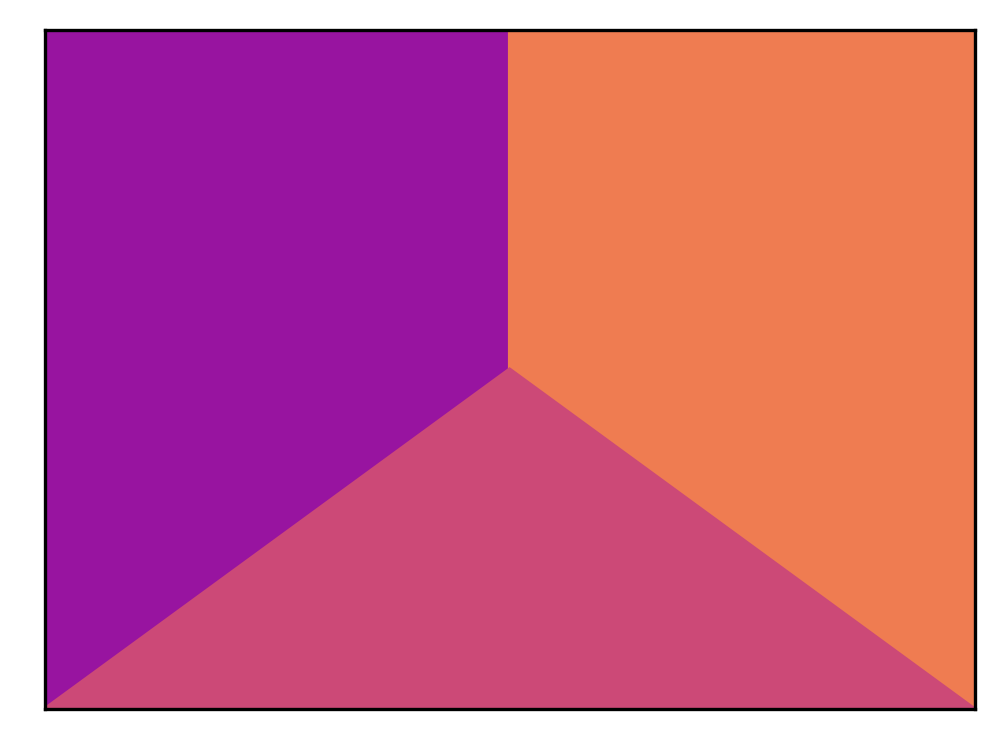

In [121]:
fig, ax = plt.subplots(dpi=300, figsize=[4, 3])
######################################## dengue, left
dots1 = [[0, 0],
        [0, 1],
        [0.5, 1],
        [0.5, 0.5],
]
e1 = mpatches.Polygon(np.array(dots1), color=colors[list(colors.keys())[0]])

#patches.append(e1)
#collection = PatchCollection(patches, color= colors)
#ax.add_collection(collection)
ax.add_patch(e1)

######################################## S_dengue, right
dots2 = [[0.5, 0.5],
        [0.5, 1],
        [1, 1],
        [1, 0],
]
e2 = mpatches.Polygon(np.array(dots2), color=colors[list(colors.keys())[1]])
ax.add_patch(e2)

######################################## Healthy, bottom
dots3 = [[0.5, 0.5],
        [0, 0],
        [1, 0],
]
e3 = mpatches.Polygon(np.array(dots3), color=colors[list(colors.keys())[2]])
ax.add_patch(e3)
    
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [4]:
# interactions with the log2_FC (S_dengue vs dengue) of ligand and receptor both up (top 50) or down (bottom 50)

log2_fc_ave = pd.read_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/new_cts/log2_fc_ave_kids.tsv', index_col=0)

cell_types = ['B_cells', 'Monocytes', 'NK_cells', 'Plasmablasts', 'T_cells', 'cDCs', 'pDCs']
both_up = defaultdict(list)
both_down = defaultdict(list)

for _, row in interactions.iterrows():
    ga = row['gene_name_a']
    gb = row['gene_name_b']
    for ct1 in cell_types:
        for ct2 in cell_types:
            ga_ct1 = log2_fc_ave.loc[ct1][log2_fc_ave.loc[ct1]['gene'] == ga]['fold_2_change'][0]
            ga_ct2 = log2_fc_ave.loc[ct2][log2_fc_ave.loc[ct2]['gene'] == ga]['fold_2_change'][0]
            gb_ct1 = log2_fc_ave.loc[ct1][log2_fc_ave.loc[ct1]['gene'] == gb]['fold_2_change'][0]
            gb_ct2 = log2_fc_ave.loc[ct2][log2_fc_ave.loc[ct2]['gene'] == gb]['fold_2_change'][0]
            
            if ct1 != ct2:
                if (ga in log2_fc_ave.loc[ct1].head(50)['gene'].tolist()) & (gb in log2_fc_ave.loc[ct2].head(50)['gene'].tolist()):
                    both_up[(ct1, ct2)].append([ga, ga_ct1, gb, gb_ct2])
                if (gb in log2_fc_ave.loc[ct1].head(50)['gene'].tolist()) & (ga in log2_fc_ave.loc[ct2].head(50)['gene'].tolist()):
                    both_up[(ct1, ct2)].append([gb, gb_ct1, ga, ga_ct2])
                if (ga in log2_fc_ave.loc[ct1].tail(50)['gene'].tolist()) & (gb in log2_fc_ave.loc[ct2].tail(50)['gene'].tolist()):
                    both_down[(ct1, ct2)].append([ga, ga_ct1, gb, gb_ct2])
                if (gb in log2_fc_ave.loc[ct1].tail(50)['gene'].tolist()) & (ga in log2_fc_ave.loc[ct2].tail(50)['gene'].tolist()):
                    both_down[(ct1, ct2)].append([gb, gb_ct1, ga, ga_ct2])
            else:
                if (ga in log2_fc_ave.loc[ct1].head(50)['gene'].tolist()) & (gb in log2_fc_ave.loc[ct2].head(50)['gene'].tolist()):
                    both_up[(ct1, ct2)].append([ga, ga_ct1, gb, gb_ct2])
                elif (gb in log2_fc_ave.loc[ct1].head(50)['gene'].tolist()) & (ga in log2_fc_ave.loc[ct2].head(50)['gene'].tolist()):
                    both_up[(ct1, ct2)].append([gb, gb_ct1, ga, ga_ct2])
                elif (ga in log2_fc_ave.loc[ct1].tail(50)['gene'].tolist()) & (gb in log2_fc_ave.loc[ct2].tail(50)['gene'].tolist()):
                    both_down[(ct1, ct2)].append([ga, ga_ct1, gb, gb_ct2])
                elif (gb in log2_fc_ave.loc[ct1].tail(50)['gene'].tolist()) & (ga in log2_fc_ave.loc[ct2].tail(50)['gene'].tolist()):
                    both_down[(ct1, ct2)].append([gb, gb_ct1, ga, ga_ct2])
                    
                    
inter_up = pd.DataFrame([])
inter_down = pd.DataFrame([])

for key in both_up.keys():
    up = pd.DataFrame(both_up[key], columns=['ga', 'log2_FC_ga', 'gb', 'log2_FC_gb'], index=pd.Index([key[0]+' '+key[1]]*len(both_up[key])))
    down = pd.DataFrame(both_down[key], columns=['ga', 'log2_FC_ga', 'gb', 'log2_FC_gb'], index=pd.Index([key[0]+' '+key[1]]*len(both_down[key])))
    inter_up = pd.concat([inter_up, up])
    inter_down = pd.concat([inter_down, down])      

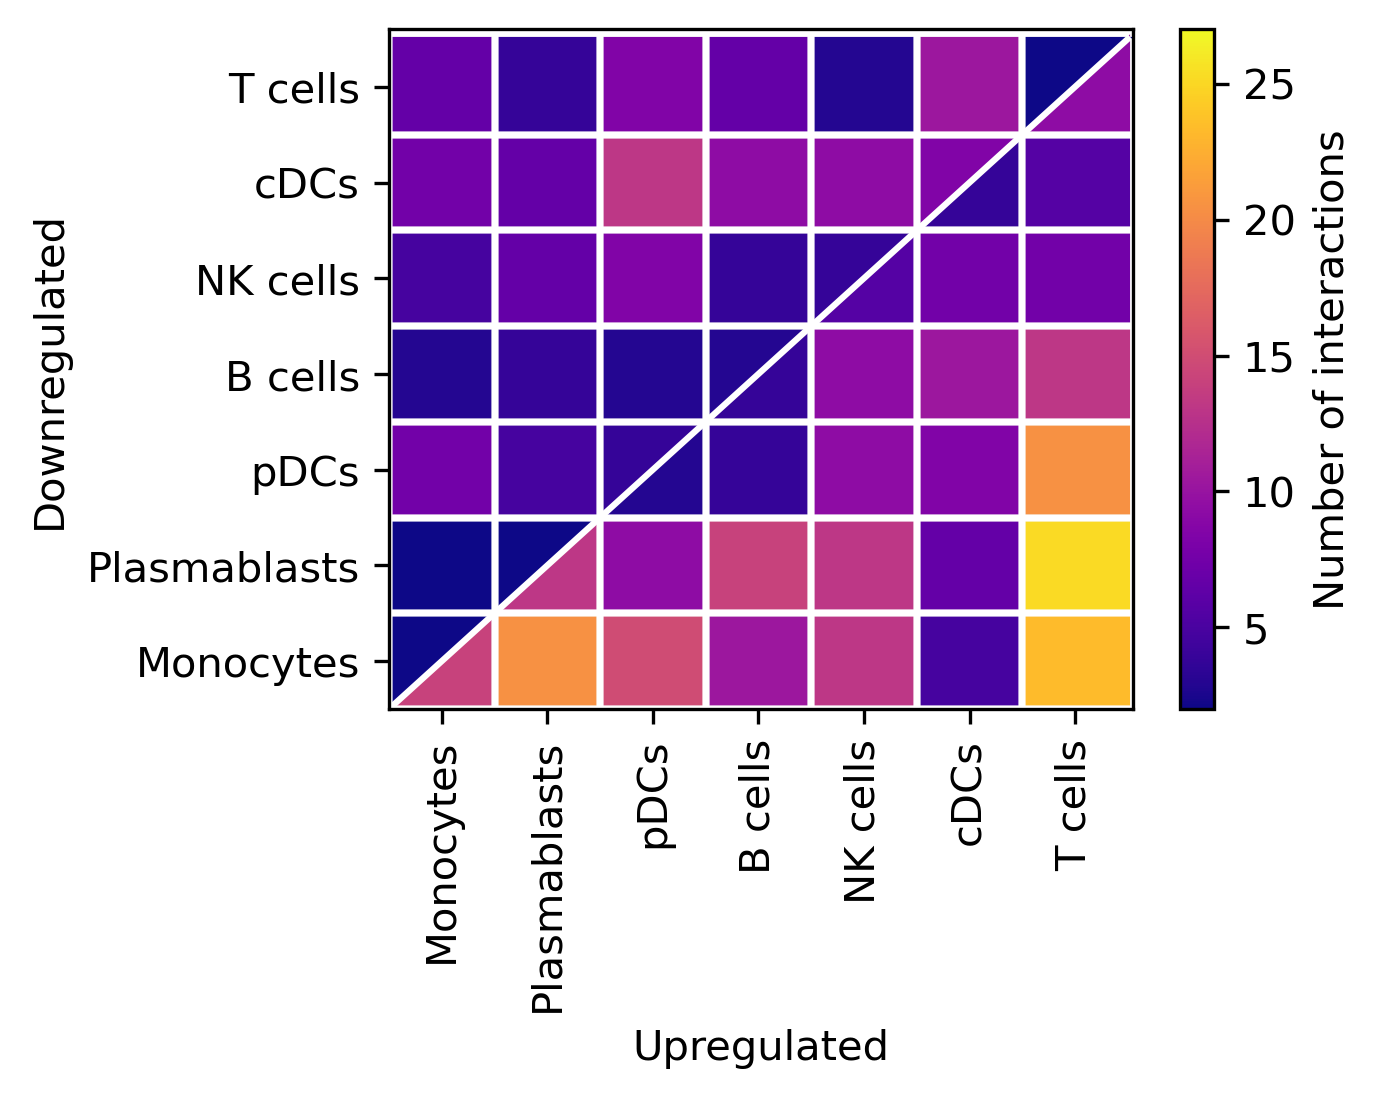

In [19]:
# up and down regulated

############################################## define dic of number of interactions
intern_up = {}
for key in both_up.keys():
    intern_up[key] = len(both_up[key])

intern_down = {}
for key in both_down.keys():
    intern_down[key] = len(both_down[key])    
    
colors_up = {}
norm_intern_up = {}
for key in intern_up.keys():
    norm_intern_up[key] = (intern_up[(key)] - min(intern_down.values()))/max(intern_up.values()) ####
    colors_up[key] = plt.cm.get_cmap('plasma')(norm_intern_up[key])

colors_down = {}
norm_intern_down = {}
for key in intern_down.keys():
    norm_intern_down[key] = (intern_down[(key)] - min(intern_down.values()))/max(intern_up.values()) ####
    colors_down[key] = plt.cm.get_cmap('plasma')(norm_intern_down[key])

############################################## optimize sequence of cell types
it = pd.DataFrame([])
ls = defaultdict(list)

for a in range(len(cell_types)):
    for b in range(len(cell_types)):
        if b <= a:
            ls[cell_types[a]].append(intern_up[(cell_types[a], cell_types[b])])
        else:
            ls[cell_types[a]].append(intern_down[(cell_types[a], cell_types[b])])
    it[cell_types[a]] = ls[cell_types[a]]
    
it.index = pd.Index(cell_types)  
# lower left: down, upper right: up

from scipy.spatial.distance import pdist 
distance = pdist(it.values) 

from scipy.cluster.hierarchy import linkage, leaves_list
lkg = linkage(distance, optimal_ordering=True)
best_order = leaves_list(lkg) 

it_new = it.iloc[best_order]

############################################## plot
fig, ax = plt.subplots(dpi=300, figsize=[4, 3])
op_cts = list(it_new.index)

for a in range(len(op_cts)):
    for b in range(len(op_cts)): 
        if a > b:
            dots = [[a, b],
                    [a, b+1],
                    [a+1, b+1],
                    [a+1, b],
            ]
            e = mpatches.Polygon(np.array(dots), color=colors_up[(op_cts[a], op_cts[b])])
            ax.add_patch(e)

        elif a == b:
            dots1 = [[a, b],
                    [a+1, b],
                    [a+1, b+1],
            ]
            e1= mpatches.Polygon(np.array(dots1), color=colors_up[(op_cts[a], op_cts[b])])
            ax.add_patch(e1)
            
            dots2 = [[a, b],
                    [a, b+1],
                    [a+1, b+1],
            ]
            e2 = mpatches.Polygon(np.array(dots2), color=colors_down[(op_cts[a], op_cts[b])])
            ax.add_patch(e2)
        
        else:
            dots3 = [[a, b],
                    [a, b+1],
                    [a+1, b+1],
                    [a+1, b],
            ]
            e3 = mpatches.Polygon(np.array(dots3), color=colors_down[(op_cts[a], op_cts[b])])
            ax.add_patch(e3)

        ax.axvline(a, c='w')
        ax.axhline(b, c='w')
ax.plot([0, 7], [0,7], c='w')
ax.axvline(len(cell_types)+1, c='w')
ax.axhline(len(cell_types)+1, c='w')
ax.set_xlim([0,7.05])
ax.set_ylim([0,7.1])
ax.set_xticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5])
ax.set_yticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5])
ax.set_xticklabels(['Monocytes', 'Plasmablasts', 'pDCs', 'B cells', 'NK cells',  'cDCs', 'T cells'], rotation=90)
ax.set_yticklabels(['Monocytes', 'Plasmablasts', 'pDCs', 'B cells', 'NK cells',  'cDCs', 'T cells'])
ax.set_xlabel('Upregulated')
ax.set_ylabel('Downregulated')
#plt.title('Number of interactions', fontsize=10)

norm = mpl.colors.Normalize(vmin=min(intern_down.values()), vmax=max(intern_up.values()))
cmap = plt.cm.get_cmap('plasma')
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, label='Number of interactions')

plt.show()

In [20]:
#inter_up.to_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/new_cts/inters_up_head50.tsv')
#inter_down.to_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/new_cts/inters_down_tail50.tsv')

In [178]:
from collections import defaultdict

adatag_children = adatag[adatag.obs['dataset'] == 'child']
cell_types = ['B_cells', 'Monocytes', 'NK_cells', 'Plasmablasts', 'T_cells', 'cDCs', 'pDCs']
conditions = ['S_dengue', 'dengue', 'DWS', 'Healthy']

adatag_ch_ct_cd = {}
for cell_type in cell_types:
    for condition in conditions:
        adatag_ch_ct_cd[(cell_type, condition)] = adatag_children[adatag_children.obs['cell_type'] == cell_type][adatag_children[adatag_children.obs['cell_type'] == cell_type].obs['Condition'] == condition] 

gene_exp = {}
for key in adatag_ch_ct_cd.keys():
    exp = (adatag_ch_ct_cd[key].X > 0).toarray().mean(axis=0)
    gene_exp[key] = pd.DataFrame(exp, index=adatag_ch_ct_cd[key].var.index, columns=[['gene_expre']])

/usr/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [94]:
# define a function to collect interactions meeting both log2_FC and exp fraction

def log2FC_fraction(comp_frac, frac_n):
    ####################################### interactions both up --> head(50), both down --> tail(50)
    log2_fc_ave = pd.read_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/new_cts/log2_fc_ave_kids.tsv', index_col=0)

    cell_types = ['B_cells', 'Monocytes', 'NK_cells', 'Plasmablasts', 'T_cells', 'cDCs', 'pDCs']
    both_up = defaultdict(list)
    both_down = defaultdict(list)

    for _, row in interactions.iterrows():
        ga = row['gene_name_a']
        gb = row['gene_name_b']
        for ct1 in cell_types:
            for ct2 in cell_types:
                ga_ct1 = log2_fc_ave.loc[ct1][log2_fc_ave.loc[ct1]['gene'] == ga]['fold_2_change'][0]
                ga_ct2 = log2_fc_ave.loc[ct2][log2_fc_ave.loc[ct2]['gene'] == ga]['fold_2_change'][0]
                gb_ct1 = log2_fc_ave.loc[ct1][log2_fc_ave.loc[ct1]['gene'] == gb]['fold_2_change'][0]
                gb_ct2 = log2_fc_ave.loc[ct2][log2_fc_ave.loc[ct2]['gene'] == gb]['fold_2_change'][0]

                #ct1_head = log2_fc_ave.loc[ct1].head(log2FC_n)['gene'].tolist()
                #ct2_head = log2_fc_ave.loc[ct2].head(log2FC_n)['gene'].tolist()
                #ct1_tail = log2_fc_ave.loc[ct1].tail(log2FC_n)['gene'].tolist()
                #ct2_tail = log2_fc_ave.loc[ct2].tail(log2FC_n)['gene'].tolist()
                
                ct1_head = log2_fc_ave.loc[ct1][log2_fc_ave.loc[ct1]['comp_frac'] >= comp_frac]['gene'].tolist()
                ct2_head = log2_fc_ave.loc[ct2][log2_fc_ave.loc[ct2]['comp_frac'] >= comp_frac]['gene'].tolist()
                ct1_tail = log2_fc_ave.loc[ct1][log2_fc_ave.loc[ct1]['comp_frac'] <= 1-comp_frac]['gene'].tolist()
                ct2_tail = log2_fc_ave.loc[ct2][log2_fc_ave.loc[ct2]['comp_frac'] <= 1-comp_frac]['gene'].tolist()

                if (ga in ct1_head) & (gb in ct2_head):
                    both_up[(ct1, ct2)].append([ga, ga_ct1, gb, gb_ct2])
                if (gb in ct1_head) & (ga in ct2_head):
                    both_up[(ct1, ct2)].append([gb, gb_ct1, ga, ga_ct2])
                if (ga in ct1_tail) & (gb in ct2_tail):
                    both_down[(ct1, ct2)].append([ga, ga_ct1, gb, gb_ct2])
                if (gb in ct1_tail) & (ga in ct2_tail):
                    both_down[(ct1, ct2)].append([gb, gb_ct1, ga, ga_ct2])
    
    ####################################### both log2_FC and exp fraction
    # log2_FC in head(50), exp fraction >= 5 % in S_dengue
    # log2_FC in tail(50), exp fraction >= 5 % in dengue
    inter_final = defaultdict(list)

    for dic, cd, k in zip([both_up, both_down], ['S_dengue', 'dengue'], ['up', 'down']):
        for key in dic.keys():
            for a in range(len(dic[key])):
                ga = dic[key][a][0] # in cell type --> key[0]
                ga_log2FC = dic[key][a][1]
                gb = dic[key][a][2] # in cell type --> key[1]
                gb_log2FC = dic[key][a][3]
                ga_in_ct1 = gene_exp[(key[0], cd)].loc[ga][0]
                gb_in_ct2 = gene_exp[(key[1], cd)].loc[gb][0]
                if (ga_in_ct1 >= frac_n) & (gb_in_ct2 >= frac_n):
                    inter_final[k].append([ga, gb, key[0], key[1], ga_log2FC, ga_in_ct1, gb_log2FC, gb_in_ct2])
                else:
                    pass

    inter_f = pd.DataFrame([])
    for key in inter_final.keys():
        inters = pd.DataFrame(inter_final[key], columns=['ga', 'gb', 'cta', 'ctb', 'ga_log2FC', 'ga_exp_frac', 'gb_log2FC', 'gb_exp_frac'], 
                             index=pd.Index([key]*len(inter_final[key])))
        inter_f =  pd.concat([inter_f, inters])
        
    return inter_f

In [103]:
inters_im_0875_001 = log2FC_fraction(0.875, 0.01)

In [104]:
inters_im_0875_001.sort_values('ga_log2FC').to_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/new_cts/inters_with_HCL_endo/its_im_0.875_0.01.tsv')

In [106]:
inters_im_0875_001.sort_values('ga_log2FC')

,ga,gb,cta,ctb,ga_log2FC,ga_exp_frac,gb_log2FC,gb_exp_frac
down,KLRD1,HLA-E,cDCs,Plasmablasts,-6.477840,0.035398,-0.526876,0.871475
down,KLRD1,HLA-E,cDCs,T_cells,-6.477840,0.035398,-0.298016,0.930783
down,KLRD1,HLA-E,cDCs,Monocytes,-6.477840,0.035398,-0.562547,0.872611
down,CCL19,CCRL2,cDCs,cDCs,-6.031390,0.026549,-3.741781,0.053097
down,FCER2,ITGAV,cDCs,cDCs,-4.129151,0.053097,-3.043288,0.035398
down,CCRL2,CCL19,cDCs,cDCs,-3.741781,0.053097,-6.031390,0.026549
down,DSC2,DSG2,cDCs,pDCs,-3.572549,0.017699,-2.519222,0.012903
down,KLRC1,HLA-E,pDCs,T_cells,-3.554036,0.032258,-0.298016,0.930783
down,KLRC1,HLA-E,pDCs,T_cells,-3.554036,0.032258,-0.298016,0.930783
down,KLRC1,HLA-E,pDCs,Plasmablasts,-3.554036,0.032258,-0.526876,0.871475


In [181]:
# define a function to collect interactions meeting both log2_FC and exp fraction
# one gene upregulate in top(50), the other gene downregulate in tail(50)

def log2FC_fraction_mix(log2FC_n, frac_n):
    ####################################### # one gene upregulate in top(50), the other gene downregulate in down(50)
    log2_fc_ave = pd.read_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/new_cts/log2_fc_ave.tsv', index_col=0)

    cell_types = ['B_cells', 'Monocytes', 'NK_cells', 'Plasmablasts', 'T_cells', 'cDCs', 'pDCs']
    mix = defaultdict(list)

    for _, row in interactions.iterrows():
        ga = row['gene_name_a']
        gb = row['gene_name_b']
        for ct1 in cell_types:
            for ct2 in cell_types:
                ga_ct1 = log2_fc_ave.loc[ct1][log2_fc_ave.loc[ct1]['gene'] == ga]['fold_2_change'][0]
                ga_ct2 = log2_fc_ave.loc[ct2][log2_fc_ave.loc[ct2]['gene'] == ga]['fold_2_change'][0]
                gb_ct1 = log2_fc_ave.loc[ct1][log2_fc_ave.loc[ct1]['gene'] == gb]['fold_2_change'][0]
                gb_ct2 = log2_fc_ave.loc[ct2][log2_fc_ave.loc[ct2]['gene'] == gb]['fold_2_change'][0]

                ct1_head = log2_fc_ave.loc[ct1].head(log2FC_n)['gene'].tolist()
                ct2_head = log2_fc_ave.loc[ct2].head(log2FC_n)['gene'].tolist()
                ct1_tail = log2_fc_ave.loc[ct1].tail(log2FC_n)['gene'].tolist()
                ct2_tail = log2_fc_ave.loc[ct2].tail(log2FC_n)['gene'].tolist()

                if (ga in ct1_head) & (gb in ct2_tail):
                    mix[(ct1, ct2)].append([ga, ga_ct1, gb, gb_ct2])
                if (gb in ct1_tail) & (ga in ct2_head):
                    mix[(ct1, ct2)].append([gb, gb_ct1, ga, ga_ct2])

    ####################################### exp fraction of genes in interactions 
    #adatag_children = adatag[adatag.obs['dataset'] == 'child']
    #cell_types = ['B_cells', 'Monocytes', 'NK_cells', 'Plasmablasts', 'T_cells', 'cDCs', 'pDCs']
    #conditions = ['S_dengue', 'dengue', 'DWS', 'Healthy']
    
    #adatag_ch_ct_cd = {}
    #for cell_type in cell_types:
    #    for condition in conditions:
    #        adatag_ch_ct_cd[(cell_type, condition)] = adatag_children[adatag_children.obs['cell_type'] == cell_type][adatag_children[adatag_children.obs['cell_type'] == cell_type].obs['Condition'] == condition] 

    #gene_exp = {}
    #for key in adatag_ch_ct_cd.keys():
    #    exp = (adatag_ch_ct_cd[key].X > 0).toarray().mean(axis=0)
    #    gene_exp[key] = pd.DataFrame(exp, index=adatag_ch_ct_cd[key].var.index, columns=[['gene_expre']])
    
    ####################################### both log2_FC and exp fraction
    # log2_FC in head(50), exp fraction >= 5 % in S_dengue
    # log2_FC in tail(50), exp fraction >= 5 % in dengue
    inter_final = []

    for cd in ['S_dengue', 'dengue']:
        for key in mix.keys():
            for a in range(len(mix[key])):
                ga = mix[key][a][0] # in cell type --> key[0]
                ga_log2FC = mix[key][a][1]
                gb = mix[key][a][2] # in cell type --> key[1]
                gb_log2FC = mix[key][a][3]
                ga_in_ct1 = gene_exp[(key[0], cd)].loc[ga][0]
                gb_in_ct2 = gene_exp[(key[1], cd)].loc[gb][0]
                if (ga_in_ct1 >= frac_n) & (gb_in_ct2 >= frac_n):
                    inter_final.append([ga, gb, key[0], key[1], ga_log2FC, ga_in_ct1, gb_log2FC, gb_in_ct2])
                else:
                    pass

    inter_f = pd.DataFrame(inter_final, columns=['ga', 'gb', 'cta', 'ctb', 'ga_log2FC', 'ga_exp_frac', 'gb_log2FC', 'gb_exp_frac'])
        
    return inter_f

In [188]:
log2FC_fraction_mix(50, 0.01).to_csv('../data/excels/log2_fc/S_dengue_vs_dengue/new_cts/inters_final_mix_50_0.01.tsv')

In [126]:
########################################### gene expression fraction in children immune cells at different conditions
adatag_children = adatag[adatag.obs['dataset'] == 'child']
cell_types = ['B_cells', 'Monocytes', 'NK_cells', 'Plasmablasts', 'T_cells', 'cDCs', 'pDCs']
conditions = ['S_dengue', 'dengue', 'DWS', 'Healthy']
from collections import defaultdict
adatag_ch_ct_cd = {}
for cell_type in cell_types:
    for condition in conditions:
        adatag_ch_ct_cd[(cell_type, condition)] = adatag_children[adatag_children.obs['cell_type'] == cell_type][adatag_children[adatag_children.obs['cell_type'] == cell_type].obs['Condition'] == condition] 

gene_exp = {}
for key in adatag_ch_ct_cd.keys():
    exp = (adatag_ch_ct_cd[key].X > 0).toarray().mean(axis=0)
    gene_exp[key] = pd.DataFrame(exp, index=adatag_ch_ct_cd[key].var.index, columns=[['gene_expre']])

########################################### gene expression fraction in endothelial cells
he_cts = ['Endothelial cell', 'Vascular endothelial cell', 'Lymphatic endothelial cell','Arterial endothelial cell']

adata_endo = sc.read_h5ad('../data/dataset_from_google/human_cell_landscape/adult_endo_HCL.h5ad')
adata_endo_ct = adata_endo[adata_endo.obs['Celltype'].isin(he_cts)]
# adata_endo_ct = {ct: adata_endo[adata_endo.obs['Celltype']==ct] for ct in he_cts}
gene_exp_he = pd.DataFrame((adata_endo_ct.X > 0).mean(axis=0), index=adata_endo_ct.var.index, columns=[['gene_expre']])

/usr/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [128]:
########################################### gene expression fraction in children immune cells at different conditions
# average of expression fraction in each patient

from numpy import * # 调用numpy所有函数

adatag_children = adatag[adatag.obs['dataset'] == 'child']

D_IDs = list(adata_children[adata_children.obs['Condition'].isin(['dengue'])].obs['ID'].astype('category').cat.categories)
SD_IDs = list(adata_children[adata_children.obs['Condition'].isin(['S_dengue'])].obs['ID'].astype('category').cat.categories)
IDs = list(adata_children.obs['ID'].astype('category').cat.categories)

cell_types = ['B_cells', 'Monocytes', 'NK_cells', 'Plasmablasts', 'T_cells', 'cDCs', 'pDCs']
conditions = ['S_dengue', 'dengue', 'DWS', 'Healthy']
from collections import defaultdict
adatag_ch_ct_cd_ID = {}
adatag_ch_ct_cd = {}
for cell_type in cell_types:
    for condition in conditions:
        adatag_ch_ct_cd[(cell_type, condition)] = adatag_children[adatag_children.obs['cell_type'] == cell_type][adatag_children[adatag_children.obs['cell_type'] == cell_type].obs['Condition'] == condition]
        for ID in IDs:
            adatag_ch_ct_cd_ID[(cell_type, condition, ID)] = adatag_ch_ct_cd[(cell_type, condition)][adatag_ch_ct_cd[(cell_type, condition)].obs['ID'] == ID]

gene_exp_ave = {}
for key in adatag_ch_ct_cd.keys():
    condition = key[1]
    exp = []
    for ID in list(adata_children[adata_children.obs['Condition'].isin([condition])].obs['ID'].astype('category').cat.categories):
        exp.append((adatag_ch_ct_cd_ID[(key[0], key[1], ID)].X > 0).toarray().mean(axis=0))
    exp_ave = np.array(exp).mean(axis=0)
    gene_exp_ave[key] = pd.DataFrame(exp_ave, index=adatag_ch_ct_cd[key].var.index, columns=[['gene_expre']])

########################################### gene expression fraction in endothelial cells
he_cts = ['Endothelial cell', 'Vascular endothelial cell', 'Lymphatic endothelial cell','Arterial endothelial cell']

adata_endo = sc.read_h5ad('../data/dataset_from_google/human_cell_landscape/adult_endo_HCL.h5ad')
adata_endo_ct = adata_endo[adata_endo.obs['Celltype'].isin(he_cts)]
# adata_endo_ct = {ct: adata_endo[adata_endo.obs['Celltype']==ct] for ct in he_cts}
gene_exp_he = pd.DataFrame((adata_endo_ct.X > 0).mean(axis=0), index=adata_endo_ct.var.index, columns=[['gene_expre']])

/usr/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [138]:
gene_exp_ave.keys()

dict_keys([('B_cells', 'S_dengue'), ('B_cells', 'dengue'), ('B_cells', 'DWS'), ('B_cells', 'Healthy'), ('Monocytes', 'S_dengue'), ('Monocytes', 'dengue'), ('Monocytes', 'DWS'), ('Monocytes', 'Healthy'), ('NK_cells', 'S_dengue'), ('NK_cells', 'dengue'), ('NK_cells', 'DWS'), ('NK_cells', 'Healthy'), ('Plasmablasts', 'S_dengue'), ('Plasmablasts', 'dengue'), ('Plasmablasts', 'DWS'), ('Plasmablasts', 'Healthy'), ('T_cells', 'S_dengue'), ('T_cells', 'dengue'), ('T_cells', 'DWS'), ('T_cells', 'Healthy'), ('cDCs', 'S_dengue'), ('cDCs', 'dengue'), ('cDCs', 'DWS'), ('cDCs', 'Healthy'), ('pDCs', 'S_dengue'), ('pDCs', 'dengue'), ('pDCs', 'DWS'), ('pDCs', 'Healthy')])

In [130]:
# define a function to get interactions between immune cells and endothelial cells
# meet standards: expression >= 0.05, and gene in immune cells in log_FC top(50) or tal(50)
#inters_he_sd ={key: inters_he[key] for key in inters_he.keys() if 'S_dengue' in }

def inters_endo(log2FC_n, comp_frac, frac_n): ### endo data from HCL: adult_endo_HCL.h5ad
    in_he_sd = defaultdict(list)
    
    no_exist = ['ADIPOQ', 'ADORA2A', 'AVPR1B', 'BMP10', 'BMP15', 'CCKAR', 'CCL27', 'CCR8', 'CER1', 'CSHL1', 'DSC1', 'EFNA2', 'EPHA8', 'FGF4', 'FGF6', 'FGF8', 'FSHB', 'FSHR', 'GALP', 'GALR3', 'GDF1', 'GDF2', 'GFRA4', 'GFRAL', 'GHSR', 'GNRHR', 'GP1BB', 'GPR151', 'GPR152', 'GPR25', 'IFNA4', 'IFNK', 'IFNL3', 'IL12B', 'IL21', 'IL25', 'IL36A', 'IL36B', 'IL9', 'INHBC', 'INSL5', 'LHCGR', 'MC3R', 'MC5R', 'MPL', 'MRGPRX1', 'MTNR1B', 'NMS', 'NPBWR1', 'NPS', 'NPSR1', 'NPVF', 'PRLH', 'PROKR2', 'PTH', 'RLN3', 'RXFP2', 'RXFP3', 'SSTR4', 'TRHR', 'TSHB', 'UTS2R', 'VSIR', 'WNT1']
    exist = [gene for gene in genes if gene not in no_exist]
    interactions_new = interactions[(interactions['gene_name_a'].isin(exist)) & (interactions['gene_name_b'].isin(exist))]
    for _, row in interactions_new.iterrows():
        ga = row['gene_name_a']
        gb = row['gene_name_b']
        for ct1 in cell_types: # immune cell
            ######### define up and down list by 'fold_2_change' amd 'comp_frac'
            #up_list = log2_fc_ave.loc[ct1].head(log2FC_n)[log2_fc_ave.loc[ct1].head(log2FC_n)['comp_frac'] >= comp_frac]['gene'].tolist()
            #down_list = log2_fc_ave.loc[ct1].tail(log2FC_n)[log2_fc_ave.loc[ct1].tail(log2FC_n)['comp_frac'] <= 1-comp_frac]['gene'].tolist()
            
            #up_list = log2_fc_ave.loc[ct1].head(log2FC_n)['gene'].tolist()
            #down_list = log2_fc_ave.loc[ct1].tail(log2FC_n)['gene'].tolist()

            # ga in immune, gb in endo
            ga_exp_sd = gene_exp_ave[(ct1, 'S_dengue')].loc[ga][0]
            ga_exp_d = gene_exp_ave[(ct1, 'dengue')].loc[ga][0]
            ga_log2FC = log2_fc_ave.loc[ct1][log2_fc_ave.loc[ct1]['gene']==ga]['fold_2_change'][0]
            ga_com_frac = log2_fc_ave.loc[ct1][log2_fc_ave.loc[ct1]['gene']==ga]['comp_frac'][0]
            gb_in_endo = gene_exp_he.loc[gb][0]

            # gb in immune, ga in endo
            gb_exp_sd = gene_exp_ave[(ct1, 'S_dengue')].loc[gb][0]
            gb_exp_d = gene_exp_ave[(ct1, 'dengue')].loc[gb][0]
            gb_log2FC = log2_fc_ave.loc[ct1][log2_fc_ave.loc[ct1]['gene']==gb]['fold_2_change'][0]
            gb_com_frac = log2_fc_ave.loc[ct1][log2_fc_ave.loc[ct1]['gene']==gb]['comp_frac'][0]
            ga_in_endo = gene_exp_he.loc[ga][0]

            ######### ga in immune, gb in endo
            #### up >=0.05 in S_dengue
            if (ga_exp_sd >= frac_n) & (gb_in_endo >= frac_n) & (ga in up_list):
                in_he_sd['up'].append([ga, gb, ct1, ga_log2FC, ga_com_frac, ga_exp_sd, ga_exp_d, gb_in_endo])
            #### down >=0.05 in dengue
            if (ga_exp_d >= frac_n) & (gb_in_endo >= frac_n) & (ga in down_list):
                in_he_sd['down'].append([ga, gb, ct1, ga_log2FC, ga_com_frac, ga_exp_sd, ga_exp_d, gb_in_endo])

            ######### gb in immune, ga in endo
            #### up >=0.05 in S_dengue    
            if (gb_exp_sd >= frac_n) & (ga_in_endo >= frac_n) & (gb in up_list):
                in_he_sd['up'].append([gb, ga, ct1, gb_log2FC, gb_com_frac, gb_exp_sd, gb_exp_d, ga_in_endo])
            #### down >=0.05 in dengue
            if (gb_exp_d >= frac_n) & (ga_in_endo >= frac_n) & (gb in down_list):
                in_he_sd['down'].append([gb, ga, ct1, gb_log2FC, gb_com_frac, gb_exp_sd, gb_exp_d, ga_in_endo])

    its_endo = pd.DataFrame([])
    for key in in_he_sd.keys():
        inters = pd.DataFrame(in_he_sd[key], columns=['ga', 'gb', 'cta', 'ga_log2FC', 'ga_com_frac',  'ga_exp_sd', 'ga_exp_d', 'gb_exp_endo'], 
                             index=pd.Index([key]*len(in_he_sd[key])))
        its_endo =  pd.concat([its_endo, inters])
        
    return its_endo

In [131]:
# define a function to get interactions between immune cells and endothelial cells
# meet standards: expression >= 0.05, and gene in immune cells in log_FC top(50) or tal(50)
#inters_he_sd ={key: inters_he[key] for key in inters_he.keys() if 'S_dengue' in }

def inters_endo_com_frac(comp_frac, frac_n): ### endo data from HCL: adult_endo_HCL.h5ad
    in_he_sd = defaultdict(list)
    
    no_exist = ['ADIPOQ', 'ADORA2A', 'AVPR1B', 'BMP10', 'BMP15', 'CCKAR', 'CCL27', 'CCR8', 'CER1', 'CSHL1', 'DSC1', 'EFNA2', 'EPHA8', 'FGF4', 'FGF6', 'FGF8', 'FSHB', 'FSHR', 'GALP', 'GALR3', 'GDF1', 'GDF2', 'GFRA4', 'GFRAL', 'GHSR', 'GNRHR', 'GP1BB', 'GPR151', 'GPR152', 'GPR25', 'IFNA4', 'IFNK', 'IFNL3', 'IL12B', 'IL21', 'IL25', 'IL36A', 'IL36B', 'IL9', 'INHBC', 'INSL5', 'LHCGR', 'MC3R', 'MC5R', 'MPL', 'MRGPRX1', 'MTNR1B', 'NMS', 'NPBWR1', 'NPS', 'NPSR1', 'NPVF', 'PRLH', 'PROKR2', 'PTH', 'RLN3', 'RXFP2', 'RXFP3', 'SSTR4', 'TRHR', 'TSHB', 'UTS2R', 'VSIR', 'WNT1']
    exist = [gene for gene in genes if gene not in no_exist]
    interactions_new = interactions[(interactions['gene_name_a'].isin(exist)) & (interactions['gene_name_b'].isin(exist))]
    for _, row in interactions_new.iterrows():
        ga = row['gene_name_a']
        gb = row['gene_name_b']
        for ct1 in cell_types: # immune cell
            ######### define up and down list by 'fold_2_change' amd 'comp_frac'
            up_list = log2_fc_ave.loc[ct1][log2_fc_ave.loc[ct1]['comp_frac'] >= comp_frac]['gene'].tolist()
            down_list = log2_fc_ave.loc[ct1][log2_fc_ave.loc[ct1]['comp_frac'] <= 1-comp_frac]['gene'].tolist()
            
            #up_list = log2_fc_ave.loc[ct1].head(log2FC_n)['gene'].tolist()
            #down_list = log2_fc_ave.loc[ct1].tail(log2FC_n)['gene'].tolist()

            # ga in immune, gb in endo
            ga_exp_sd = gene_exp_ave[(ct1, 'S_dengue')].loc[ga][0]
            ga_exp_d = gene_exp_ave[(ct1, 'dengue')].loc[ga][0]
            ga_log2FC = log2_fc_ave.loc[ct1][log2_fc_ave.loc[ct1]['gene']==ga]['fold_2_change'][0]
            ga_com_frac = log2_fc_ave.loc[ct1][log2_fc_ave.loc[ct1]['gene']==ga]['comp_frac'][0]
            gb_in_endo = gene_exp_he.loc[gb][0]

            # gb in immune, ga in endo
            gb_exp_sd = gene_exp_ave[(ct1, 'S_dengue')].loc[gb][0]
            gb_exp_d = gene_exp_ave[(ct1, 'dengue')].loc[gb][0]
            gb_log2FC = log2_fc_ave.loc[ct1][log2_fc_ave.loc[ct1]['gene']==gb]['fold_2_change'][0]
            gb_com_frac = log2_fc_ave.loc[ct1][log2_fc_ave.loc[ct1]['gene']==gb]['comp_frac'][0]
            ga_in_endo = gene_exp_he.loc[ga][0]

            ######### ga in immune, gb in endo
            #### up >=0.05 in S_dengue
            if (ga_exp_sd >= frac_n) & (gb_in_endo >= frac_n) & (ga in up_list):
                in_he_sd['up'].append([ga, gb, ct1, ga_log2FC, ga_com_frac, ga_exp_sd, ga_exp_d, gb_in_endo])
            #### down >=0.05 in dengue
            if (ga_exp_d >= frac_n) & (gb_in_endo >= frac_n) & (ga in down_list):
                in_he_sd['down'].append([ga, gb, ct1, ga_log2FC, ga_com_frac, ga_exp_sd, ga_exp_d, gb_in_endo])

            ######### gb in immune, ga in endo
            #### up >=0.05 in S_dengue    
            if (gb_exp_sd >= frac_n) & (ga_in_endo >= frac_n) & (gb in up_list):
                in_he_sd['up'].append([gb, ga, ct1, gb_log2FC, gb_com_frac, gb_exp_sd, gb_exp_d, ga_in_endo])
            #### down >=0.05 in dengue
            if (gb_exp_d >= frac_n) & (ga_in_endo >= frac_n) & (gb in down_list):
                in_he_sd['down'].append([gb, ga, ct1, gb_log2FC, gb_com_frac, gb_exp_sd, gb_exp_d, ga_in_endo])

    its_endo = pd.DataFrame([])
    for key in in_he_sd.keys():
        inters = pd.DataFrame(in_he_sd[key], columns=['ga', 'gb', 'cta', 'ga_log2FC', 'ga_com_frac',  'ga_exp_sd', 'ga_exp_d', 'gb_exp_endo'], 
                             index=pd.Index([key]*len(in_he_sd[key])))
        its_endo =  pd.concat([its_endo, inters])
        
    return its_endo

In [135]:
its_endo_0875_005 = inters_endo_com_frac(0.875, 0.05) # 0.875 means 28 out of 32 are positive

In [136]:
its_endo_0875_005.sort_values('ga_log2FC').to_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/new_cts/inters_with_HCL_endo/its_endo_0.875_0.05.tsv')

In [137]:
its_endo_0875_005.sort_values('ga_log2FC')

,ga,gb,cta,ga_log2FC,ga_com_frac,ga_exp_sd,ga_exp_d,gb_exp_endo
down,KLRD1,HLA-E,cDCs,-6.477840,0.09375,0.006944,0.055693,0.629906
down,IL6ST,IL6,cDCs,-5.559069,0.09375,0.050180,0.122256,0.080183
down,FAM3C,LAMP1,B_cells,-0.810552,0.00000,0.127608,0.157174,0.080183
down,CD74,APP,Plasmablasts,-0.717969,0.09375,0.935480,0.979615,0.356610
down,CD74,MIF,Plasmablasts,-0.717969,0.09375,0.935480,0.979615,0.209487
down,CD74,APP,Monocytes,-0.587368,0.12500,0.990860,0.996881,0.356610
down,CD74,MIF,Monocytes,-0.587368,0.12500,0.990860,0.996881,0.209487
down,TYROBP,CD47,Monocytes,-0.575500,0.12500,0.981337,0.988653,0.091019
down,TYROBP,CD47,NK_cells,-0.507540,0.00000,0.922049,0.965931,0.091019
down,TYROBP,CD47,pDCs,-0.381596,0.09375,0.920277,0.970098,0.091019


In [92]:
its_endo_50_0875_002 = inters_endo(50, 0.875, 0.02)
its_endo_50_0875_002.to_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/new_cts/inters_with_HCL_endo/its_endo_50_0.875_0.02.tsv')

In [ ]:
from log2_FC_functions import log2_FC_all

gbs = ['B_cells', 'Monocytes', 'NK_cells', 'Plasmablasts', 'T_cells', 'cDCs', 'pDCs']
    
adata_gb = {}
log2_fc_all = {}
df_log2_fc = {}
log2_fc_by_genes = pd.DataFrame([])
log2_fc_ave = pd.DataFrame([])

#top_log2_fc = {}
#top_log2_fcs = pd.DataFrame([])

for gb in gbs:
    adata_gb[gb] = adata[adata.obs['cell_type'] == gb]
    
    log2_fc_all[gb] = log2_FC_all(genes, adata_gb[gb], 'S_dengue', 'dengue', 'child')[1]
    log2_fc_all[gb]['cell_type']=[gb]*log2_fc_all[gb].shape[0]
    log2_fc_ave = pd.concat([log2_fc_ave, log2_fc_all[gb]])
    
    df_log2_fc[gb] = log2_FC_all(genes, adata_gb[gb], 'S_dengue', 'dengue', 'child')[2]
    df_log2_fc[gb][('', 'cell_type')]=[gb]*log2_fc_all[gb].shape[0]
    log2_fc_by_genes = pd.concat([log2_fc_by_genes, df_log2_fc[gb]])

log2_fc_ave['gene'] = log2_fc_ave.index.values
log2_fc_ave = log2_fc_ave.set_index('cell_type')

log2_fc_by_genes[(' ','gene')]=log2_fc_by_genes.index.values
log2_fc_by_genes = log2_fc_by_genes.set_index(('', 'cell_type'))
log2_fc_by_genes.index.name = 'index'
#    top_log2_fc[gb] = list(log2_fc_all[gb][:20].index)
#    top_log2_fcs[gb] = top_log2_fc[gb]
#top_log2_fcs.to_excel('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/new_cts/top20_log2_fc_in_cts.xls')


#from pandas import ExcelWriter
#with ExcelWriter('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/new_cts/log2_fc_by_genes_in_cts.xls') as writer:
#    for gb in gbs:
#        df_log2_fc[gb].to_excel(writer, sheet_name=gb)

#with ExcelWriter('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/new_cts/log2_fc_all_in_cts.xls') as writer:
#    for gb in gbs:
#        log2_fc_all[gb].to_excel(writer, sheet_name=gb)


#log2_fc_ave.to_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/new_cts/log2_fc_ave.tsv')
#log2_fc_by_genes.to_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/new_cts/log2_fc_by_genes.tsv')

In [142]:
adata_endo.obs['Celltype'].value_counts().sum()

6101